In [1]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install --quiet rioxarray
    !pip3 install pyspatialml
    !pip3 install earthpy
    !pip3 install xarray
    !pip3 install rasterio
    !pip install matplotlib-scalebar
    !pip install XlsxWriter
    !pip install shap
    !pip3 install rioxarray
    !pip install plotnine pdpbox



In [2]:
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/feature selection/Modelling/Data/'
#raster_paths = data_path + 'Raster data/'
AOI = data_path + '../shapefiles/Copy of AOI_Hessen.shp'
#print(f"The file size is {os.path.getsize(DEM)/1e6} MB")
Model_path = '/content/drive/MyDrive/feature selection/Modelling/Models'
raster_path = data_path + 'Raster data'

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import os
import fiona
import glob
import rasterio as rio
from rasterio.merge import merge
from rasterio.plot import show
import xarray as xr
# Plotting extent is used to plot raster & vector data together
from rasterio.plot import plotting_extent

import earthpy as et
import earthpy.plot as ep

# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="white")

# DATA PROCESSING

In [4]:
import geopandas as gpd
import os
import fiona
import earthpy.spatial as es

from osgeo import ogr, gdal, osr
from osgeo import gdalconst
import subprocess
from osgeo import osr

In [5]:
gpkg_path = data_path + 'GRP_Analysis.gpkg'
layers = fiona.listlayers(gpkg_path)
print(layers)
data = gpd.read_file(gpkg_path, layer='train_data')
df_tes = gpd.read_file(gpkg_path, layer='test_data')
master_df = gpd.read_file(gpkg_path, layer='Final_model_data')


['Final Rn data', 'Removed Rn Data', 'Rn_mstr', 'df_grids', 'Final_model_data', 'train_data', 'test_data']


In [6]:
data.columns

Index(['OSTWERT', 'NORDWERT', 'Rn_Poten', 'PERMEABILI', 'RADON_RN_2',
       'RADON_RN_3', 'GRP_conc', 'Geo_class', 'AnnPreci_1', 'CP_CaC03_H',
       'CP_CEC_Hes', 'CP_CN_Hess', 'CP_N_Hesse', 'CP_P_Hesse', 'CP_PhH20_H',
       'DEM', 'HC_FC_Weig', 'HC_KS_Weig', 'HC_SWC_Wei', 'HC_WP_Ger_',
       'HP_FC_Hess', 'Lin_Densit', 'Pp_Clay_He', 'Pp_CoarseP', 'Pp_Sand_He',
       'Pp_Silt_He', 'Prec_2020_', 'Prec_2022_', 'Prec_JJA_2', 'Prec_JJA_3',
       'Prec_MAM_2', 'Prec_MAM_3', 'Prec_SON_2', 'Prec_SON_3', 'Precip_202',
       'Precip_203', 'Precip_204', 'Precip_205', 'Soil_Tem_1', 'Soil_Tem_3',
       'SoilMois_9', 'SoilTemp_2', 'TempAir_19', 'TWI_Hessen', 'Uranium_ge',
       'grids_6k', 'grids_4k', 'grids_10pa', 'Carbononif', 'Dev_low',
       'Dev_mid', 'Dev_carb_p', 'Dev_up', 'Holocene', 'Palaeo_met',
       'Paleo_igne', 'Perm_low_m', 'Perm_up_Ze', 'Pleistocen', 'Tert_fluv',
       'Tert_volc', 'Trias_bund', 'Trias_musc', 'Trias_keup', 'geometry'],
      dtype='object')

In [7]:
df_tes.describe()

,OSTWERT,NORDWERT,Rn_Poten,RADON_RN_2,RADON_RN_3,AnnPreci_1,CP_CaC03_H,CP_CEC_Hes,CP_CN_Hess,CP_N_Hesse,...,Palaeo_met,Paleo_igne,Perm_low_m,Perm_up_Ze,Pleistocen,Tert_fluv,Tert_volc,Trias_bund,Trias_musc,Trias_keup
count,301.000000,3.010000e+02,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,...,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000
mean,479246.669087,5.554984e+06,29.622436,23661.936810,48.138444,23.767997,-203.707335,-216.586622,-220.729749,-230.347929,...,0.086379,0.013289,0.013289,0.013289,0.102990,0.016611,0.046512,0.139535,0.009967,0.003322
std,28074.027420,5.045709e+04,36.716057,64213.863213,66.047152,579.748146,1514.103692,1511.987362,1511.334542,1509.846133,...,0.281390,0.114700,0.114700,0.114700,0.304452,0.128023,0.210941,0.347081,0.099500,0.057639
min,421521.000000,5.477873e+06,2.040020,0.000000,2.062400,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,463305.000000,5.521644e+06,13.020990,0.000000,18.000000,48.000000,12.014000,10.711200,9.986980,1.610080,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,465370.715200,5.524474e+06,20.546000,9147.733333,32.318254,52.250000,29.964000,14.959300,11.493500,1.922970,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,486617.332000,5.583984e+06,35.180000,26686.091000,56.865070,64.166700,44.469100,18.938000,13.500000,2.680460,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,573608.000000,5.696806e+06,409.430000,720896.000000,720.896000,98.000000,110.980000,33.489200,21.663100,5.161880,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
def remove_negative(dataframe_negative):
  numeric_cols = dataframe_negative.select_dtypes(include='number').columns
  dataframe_negative[numeric_cols] = dataframe_negative[numeric_cols].applymap(lambda x: max(0, x))
  return dataframe_negative

In [9]:
columns_to_drop = ['OSTWERT', 'NORDWERT','PERMEABILI', 'RADON_RN_2',
                   'RADON_RN_3', 'GRP_conc', 'Geo_class','TWI_Hessen','geometry']
df_test_ = df_tes.drop(columns_to_drop, axis=1)
df_train_ = data.drop(columns_to_drop, axis=1)



df_test = remove_negative(df_test_)
df_train = remove_negative(df_train_)

datax=remove_negative(data)
data_testx=remove_negative(df_tes)

In [10]:
df_test.describe()

,Rn_Poten,AnnPreci_1,CP_CaC03_H,CP_CEC_Hes,CP_CN_Hess,CP_N_Hesse,CP_P_Hesse,CP_PhH20_H,DEM,HC_FC_Weig,...,Palaeo_met,Paleo_igne,Perm_low_m,Perm_up_Ze,Pleistocen,Tert_fluv,Tert_volc,Trias_bund,Trias_musc,Trias_keup
count,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,...,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000
mean,29.622436,56.987266,28.827549,15.948262,11.805134,2.186954,36.180007,6.321197,211.083056,29.900262,...,0.086379,0.013289,0.013289,0.013289,0.102990,0.016611,0.046512,0.139535,0.009967,0.003322
std,36.716057,12.233951,21.083273,7.073051,3.099793,0.944330,13.191879,1.325021,137.075976,1.984261,...,0.281390,0.114700,0.114700,0.114700,0.304452,0.128023,0.210941,0.347081,0.099500,0.057639
min,2.040020,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,86.000000,21.289000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.020990,48.000000,12.014000,10.711200,9.986980,1.610080,25.484800,5.869290,88.000000,28.264000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,20.546000,52.250000,29.964000,14.959300,11.493500,1.922970,41.492700,6.734210,153.000000,30.038000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,35.180000,64.166700,44.469100,18.938000,13.500000,2.680460,45.068500,7.231610,308.000000,31.213500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,409.430000,98.000000,110.980000,33.489200,21.663100,5.161880,58.023400,7.794290,698.000000,34.913000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
## reproject raster
from rasterio.crs import CRS
import rioxarray as rxr
from pyspatialml import Raster
from pyspatialml.preprocessing import xy_coordinates, distance_to_corners
import pyspatialml.datasets.meuse as ms
from copy import deepcopy
from tempfile import NamedTemporaryFile
from rasterio.warp import calculate_default_transform, reproject, Resampling
import geopandas as gpd
from shapely.geometry import mapping

#AOI_file = gpd.read_file(AOI)


### Encoding Geology based on RN_Values

In [12]:
from sklearn.preprocessing import OrdinalEncoder
oenc = OrdinalEncoder()

In [13]:
def encode_geology_features(ra_data):
  oenc = OrdinalEncoder(categories = [['Paleozoic (metamorph)', 'Holocene','Paleozoic igneous rocks','Permian, Upper (Zechstein)',
                                      'Triassic, Lower (Buntsandstein)', 'Devonian, Lower','Devonian, Upper','Carboniferous',
                                      'Devonian to Carboniferous (plutonites)','Tertiary (fluviatile)','Permian, Lower to Middle (Rotliegend)',
                                      'Triassic, Middle (Muschelkalk)','Devonian, Middle','Tertiary (volcanites)','Triassic, Middle to Upper (Keuper)',
                                      'Pleistocene']])
  ra_data['Geol_rank'] = oenc.fit_transform(ra_data.loc[:,['hlnug_right']])
  transformed_data = ra_data.drop(columns=['hlnug_right'], axis=1)
  return transformed_data
#df_train = encode_geology_features(df_train_)
#df_test = encode_geology_features(df_test_)

## Filtering training/test data

In [14]:
df_train.columns

Index(['Rn_Poten', 'AnnPreci_1', 'CP_CaC03_H', 'CP_CEC_Hes', 'CP_CN_Hess',
       'CP_N_Hesse', 'CP_P_Hesse', 'CP_PhH20_H', 'DEM', 'HC_FC_Weig',
       'HC_KS_Weig', 'HC_SWC_Wei', 'HC_WP_Ger_', 'HP_FC_Hess', 'Lin_Densit',
       'Pp_Clay_He', 'Pp_CoarseP', 'Pp_Sand_He', 'Pp_Silt_He', 'Prec_2020_',
       'Prec_2022_', 'Prec_JJA_2', 'Prec_JJA_3', 'Prec_MAM_2', 'Prec_MAM_3',
       'Prec_SON_2', 'Prec_SON_3', 'Precip_202', 'Precip_203', 'Precip_204',
       'Precip_205', 'Soil_Tem_1', 'Soil_Tem_3', 'SoilMois_9', 'SoilTemp_2',
       'TempAir_19', 'Uranium_ge', 'grids_6k', 'grids_4k', 'grids_10pa',
       'Carbononif', 'Dev_low', 'Dev_mid', 'Dev_carb_p', 'Dev_up', 'Holocene',
       'Palaeo_met', 'Paleo_igne', 'Perm_low_m', 'Perm_up_Ze', 'Pleistocen',
       'Tert_fluv', 'Tert_volc', 'Trias_bund', 'Trias_musc', 'Trias_keup'],
      dtype='object')

In [15]:
#y = df['Rn_Poten']
#y_test = df_test['Rn_Poten']
#X = df.drop(['Rn_Poten'], axis=1)
#X_cat1 =df.drop(['Rn_Poten', 'Geo_rank'], axis=1)
df_corr = df_train.drop(['grids_6k', 'grids_4k',
       'grids_10pa', 'Carbononif', 'Dev_low', 'Dev_mid', 'Dev_carb_p',
       'Dev_up', 'Holocene', 'Palaeo_met', 'Paleo_igne', 'Perm_low_m',
       'Perm_up_Ze', 'Pleistocen', 'Tert_fluv', 'Tert_volc', 'Trias_bund',
       'Trias_musc', 'Trias_keup'], axis=1)

df_corr_Geo = df_train[['Rn_Poten','Carbononif', 'Dev_low', 'Dev_mid', 'Dev_carb_p',
       'Dev_up', 'Holocene', 'Palaeo_met', 'Paleo_igne', 'Perm_low_m',
       'Perm_up_Ze', 'Pleistocen', 'Tert_fluv', 'Tert_volc', 'Trias_bund',
       'Trias_musc', 'Trias_keup',]]

#---------------------------------------------------------------------------------------------------#

def get_data_to_process(df):
  y = df['Rn_Poten']
  X = df.drop(['Rn_Poten'], axis=1)
  X_geo_raster =df.drop(['Rn_Poten', 'Geo_rank',], axis=1)
  return y, X, X_geo_raster

def get_data_to_process_coords(df):
  y = df['Rn_Poten']
  X = df.drop(['Rn_Poten', 'geometry'], axis=1)
  X_geo_raster =df.drop(['Rn_Poten', 'Geo_rank','geometry'], axis=1)
  return y, X, X_geo_raster

In [16]:
#y, X, X_geo_raster = get_data_to_process_coords(df_train)

### Importing sklearn tools for processing

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [18]:
def encoder(data_to_encode):
  encoder=OneHotEncoder(sparse=False)

  train_X_encoded = pd.DataFrame(encoder.fit_transform(data_to_encode[['hlnug_rank']]))

  train_X_encoded.columns = encoder.get_feature_names_out(['hlnug_rank'])

  data_without_Geo_Ra = data_to_encode.drop(['hlnug_rank'] ,axis=1)

  ## OH_X_train contains encoded Geology
  OH_X_train= pd.concat([data_without_Geo_Ra, train_X_encoded ], axis=1)
  return OH_X_train, data_without_Geo_Ra

### scaling the data

In [19]:
seasonal_variables=['Prec_2022_', 'Prec_JJA_2', 'Prec_JJA_3','Prec_MAM_2', 'Prec_MAM_3',
                    'Prec_SON_2','Prec_SON_3', 'Precip_202', 'Precip_203', 'Precip_204',
                    'Precip_205', 'Soil_Tem_1','Soil_Tem_3','SoilTemp_2',]

In [20]:
# scaling data
from sklearn.preprocessing import MinMaxScaler
Scaler = MinMaxScaler()

def scaled_data(unscaled_):
  data_drop = unscaled_.drop(['grids_4k','grids_10pa'], axis=1)

  feature_to_exclude = 'grids_6k'

  # Identify features to scale (excluding the one to exclude)
  features_to_scale = [col for col in data_drop.columns if col != feature_to_exclude]

  # Scale the selected features
  data_drop[features_to_scale] = pd.DataFrame(Scaler.fit_transform(data_drop[features_to_scale]),
                                                      columns=data_drop[features_to_scale].columns)
  #scaled_OH_X_train = pd.DataFrame(scaler.fit_transform(data_drop),columns=data_drop.columns)

  return data_drop
train_scaled = scaled_data(df_train)
test_scaled = scaled_data(df_test)


#---------------------------------------------------------------------------------------------------#
## OH_Train1 = drop all seasonal values and Geo_rank

def drop_all_seasonal_values(scaled_data):
  Scaled_multiannual = scaled_data.drop(seasonal_variables, axis=1)

  return Scaled_multiannual
train_Scaled_multiannual_ = drop_all_seasonal_values(train_scaled)
test_Scaled_multiannual_ = drop_all_seasonal_values(test_scaled)

train_Scaled_multiannual = train_Scaled_multiannual_.dropna()
test_Scaled_multiannual = test_Scaled_multiannual_.dropna()

### data without seasonal values

In [21]:
## ohne_seasonal = drop all seasonal values
def without_seasonal_variables(input_data):
  ohne_seasonal = input_data.drop(columns=(seasonal_variables),axis=1)
  return ohne_seasonal

train_multiannual = without_seasonal_variables(df_train)
test_multiannual = without_seasonal_variables(df_test)

### generating groups

In [22]:
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor


from sklearn.model_selection import KFold, LeaveOneGroupOut, cross_validate
from numpy import absolute
from sklearn.pipeline import Pipeline

## specifying groups

def group_folds(df):
  x1 = data.copy()

  groups = x1.pop('grids_6k')
  groups_4k = x1.pop('grids_4k')
  groups_10pts = x1.pop('grids_10pa')
  return groups, groups_4k, groups_10pts

groups, groups_4k, groups_10pts = group_folds(data)

### plotting correlation

In [23]:
def get_correlation_plot(input_data):
  input_data = input_data.apply(pd.to_numeric)

  # plotting correlation map
  sns.heatmap(input_data.corr(), annot=True,
              cmap='terrain',linewidth=.5, fmt=".2f")
  fig= plt.gcf()
  fig.set_size_inches(50,50)

  return plt.show()
get_correlation_plot(df_corr)

Output hidden; open in https://colab.research.google.com to view.

In [24]:
from plotnine import*

In [25]:
def make_correlation_data(dataframe):

  data_corr = dataframe.corr()

  dataw = []
  for val1 in data_corr.index:
      for val2 in data_corr.columns:
          dataw.append([val1, val2, data_corr.loc[val1, val2]])

  data_corr = pd.DataFrame(data=dataw, columns=["Val1", "Val2", "Correlation"])
  return data_corr

def get_corr_matrix(melted_dataframe, str:None, figsize=None):
  heatmap = ggplot(data= melted_dataframe) +\
  geom_tile(mapping=aes(x="Val1", y="Val2", fill="Correlation"))+\
  geom_text(aes(x="Val1", y="Val2", label='Correlation'),format_string='{:.2f}', size=10)+\
  labs(x="", y="", title=f"Corelation heatmap between GRP and {str}")+\
  theme(figure_size=figsize, plot_title=element_text(hjust=0.5),
        axis_text_x=element_text(angle=90, hjust=1))+\
  scale_fill_cmap(cmap_name="Blues")

  return heatmap

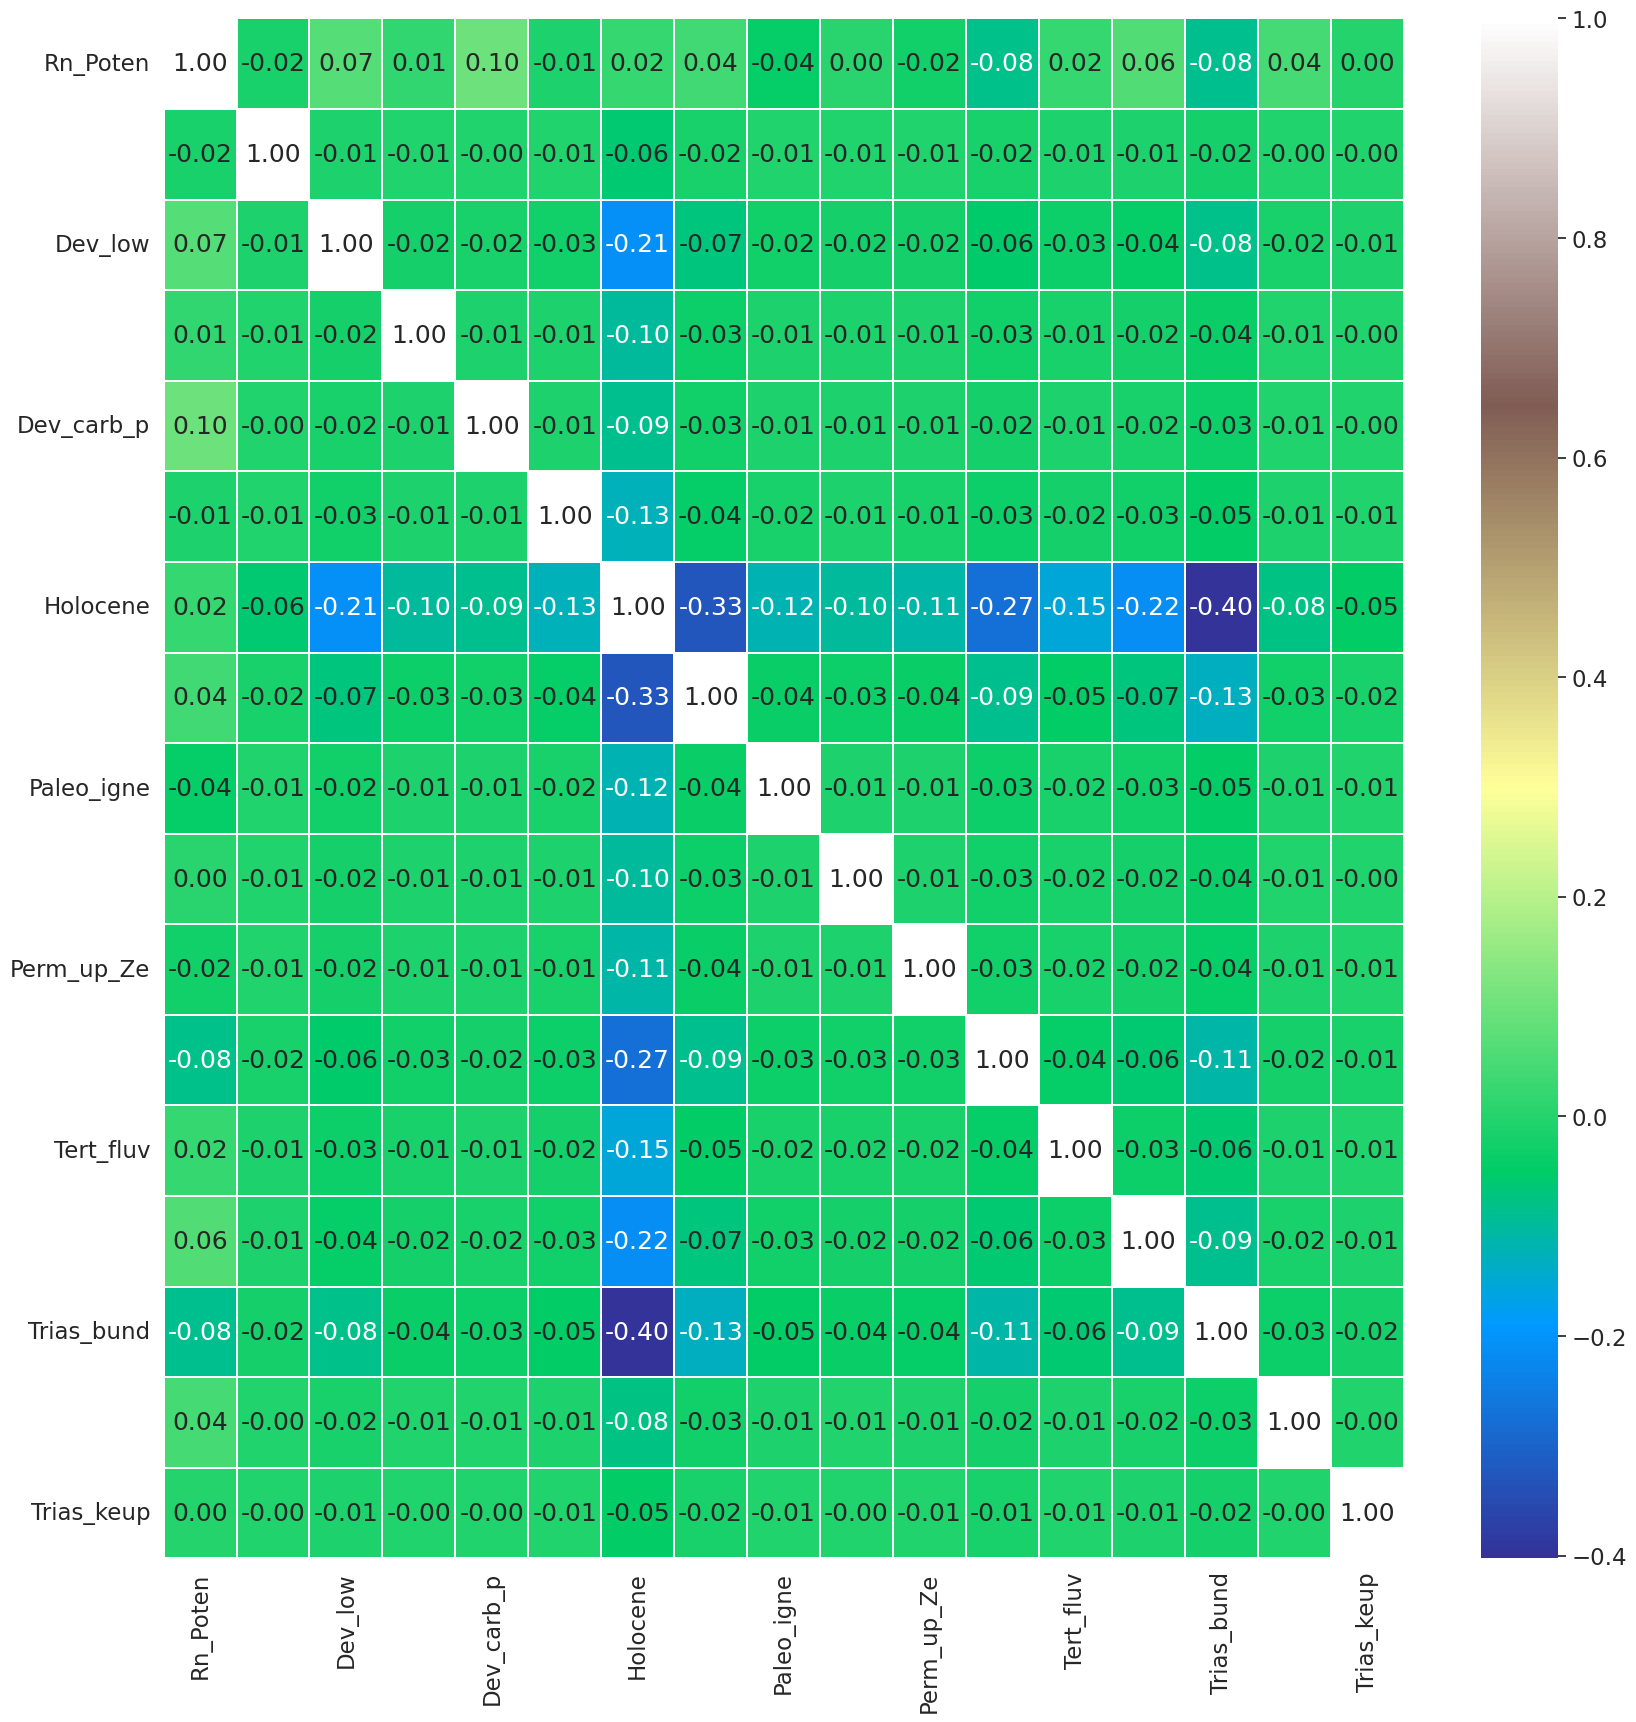

In [26]:
def get_correlation_plot_xy(input_data):
  input_data = input_data.apply(pd.to_numeric)

  # plotting correlation map
  sns.heatmap(input_data.corr(), annot=True,
              cmap='terrain',linewidth=.2, fmt=".2f")
  fig= plt.gcf()
  fig.set_size_inches(20,20)

  return plt.show()
get_correlation_plot_xy(df_corr_Geo)

### Optimising Random Model

In [27]:
from numpy import sqrt, mean
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

loo = LeaveOneGroupOut()


# Creating datasets

In [28]:
from sklearn.model_selection import GroupKFold

drop_feature_selection = ['grids_4k', 'grids_10pa']
group_column='grids_6k'
target_column='Rn_Poten'

df_train_SFS = df_train.drop(drop_feature_selection, axis =1)
df_test_SFS = df_test.drop(drop_feature_selection, axis =1)

df_multiannual_SFS= train_multiannual.drop(drop_feature_selection, axis =1)
df_test_multiannual_SFS= test_multiannual.drop(drop_feature_selection, axis =1)

#df_train_Scaled_multiannual = train_Scaled_multiannual.drop(drop_feature_selection, axis =1)

#df_test_wo_grids = df_test_wo_grid4K.drop(['grids_4k'], axis =1)
#df_test_wo_seasonal = df_test_wo_grid4K.drop(seasonal_data, axis =1)

#df_train_wo_grids = df_train.drop(drop_grids, axis=1)
#df_train_wo_seasonal = df_train_wo_grids.drop(seasonal_data, axis =1)
#df_testGPT.columns

In [29]:
def relative_squared_error(true, pred):
    true_mean = np.mean(true)
    squared_error_num = np.sum(np.square(true - pred))
    squared_error_den = np.sum(np.square(true - true_mean))
    rse_loss = squared_error_num / squared_error_den
    return rse_loss

def quantile_loss(true, pred, gamma):
    val1 = gamma * np.abs(true - pred)
    val2 = (1-gamma) * np.abs(true - pred)
    q_loss = np.where(true >= pred, val1, val2)
    return q_loss

def r2_adj(response,true,pred):
    x= response
    r2=r2_score(true,pred)
    n = x.shape[0]
    p = x.shape[1]
    return 1-(1-r2)*(n-1)/(n-p-1)

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.feature_selection import f_regression

In [31]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [32]:
#def get_feature_groups(dataframe):
feature_groups_list=['Carbononif','Dev_low', 'Dev_mid', 'Dev_carb_p', 'Dev_up',
                'Holocene', 'Palaeo_met','Paleo_igne', 'Perm_low_m', 'Perm_up_Ze',
                'Pleistocen', 'Tert_fluv','Tert_volc', 'Trias_bund', 'Trias_musc',
                'Trias_keup']
#feature_groups = [dataframe.columns.get_loc(col) for col in feature_groups_list]
#return feature_groups

#feature_group_tuple = [df_train_SFS.columns.get_loc(col) for col in feature_groups_list]
#feature_group_rf = [[item] for item in feature_group_tuple]

In [33]:
def feature_groups(dataframe):

 # irrelevant_cols=['Rn_Poten','grids_4k']
  filtered_dataframe= dataframe.drop(columns=['Rn_Poten','grids_6k'], axis=1)
  ungrouped_features= filtered_dataframe.drop(columns=feature_groups_list, axis=1)
  ungrouped_features_tuple = [filtered_dataframe.columns.get_loc(col) \
                        for col in ungrouped_features]
  ungrouped_features_list = [[item] for item in ungrouped_features_tuple]

  grouped_features_tuple = [filtered_dataframe.columns.get_loc(col) \
                          for col in feature_groups_list]
  grouped_features_list = [grouped_features_tuple]
  feature_group_all = ungrouped_features_list + grouped_features_list

  #index_to_remove= [[item] for item in [dataframe.columns.get_loc(col) for col in irrelevant_cols]]
  #feature_group_= [item for item in feature_group_all if item not in index_to_remove]

  return feature_group_all

In [34]:
def SFS_Algorithm(data_, groups, base_estimator):
  X = data_.drop(columns=[target_column, group_column])
  y = data_[target_column]
  groups = data_[group_column]
  #feat_groups=feature_groups(data_)
  sfs = SFS(base_estimator,
            k_features=(10, 15),
            forward=True,
            floating=False,
            scoring='r2',
            verbose=2,
            cv=loo)
  sfs = sfs.fit(X, y, groups=groups)
  fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')
  Selected_Features = sfs.k_feature_names_
  sfs_metrics = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
  plt.title(f'SFS {base_estimator.__class__.__name__} :...(w. StdErr)')

  print('best combination (ACC: %.3f): %s\n' % (sfs.k_score_, sfs.k_feature_idx_))
  print('all subsets:\n', sfs.subsets_)

  plt.grid()
  plt.show()
  return fig, Selected_Features, sfs_metrics

In [35]:
def SFS_Algorithm_groups(data_, groups, base_estimator):
  X = data_.drop(columns=[target_column, group_column])
  y = data_[target_column]
  groups = data_[group_column]
  feat_groups=feature_groups(data_)
  sfs = SFS(base_estimator,
            k_features=(10, 15),
            forward=True,
            floating=False,
            feature_groups=feat_groups,
            scoring='r2',
            verbose=2,
            cv=loo)
  sfs = sfs.fit(X, y, groups=groups)
  fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')
  Selected_Features = sfs.k_feature_names_
  sfs_metrics = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
  plt.title(f'SFS {base_estimator.__class__.__name__} :...(w. StdErr)')
  plt.grid()
  plt.show()
  return fig, Selected_Features, sfs_metrics

In [36]:
print(len(feature_groups(df_train_SFS)))
print(df_train_SFS.shape[1])

37
54


In [37]:
from sklearn.ensemble import GradientBoostingRegressor
#gbm = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.1, random_state=42)
from sklearn.svm import SVR
from sklearn.feature_selection import f_regression
#Tuned_SVR = SVR(kernel='rbf', C=250.0, epsilon=0.1)

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold

model_mlpr = MLPRegressor(max_iter= 100000, hidden_layer_sizes=(50,50,50), activation='tanh',
                       learning_rate='constant',alpha=0.0001,
                       solver='adam', random_state=42)

# MODELS

## RF Regressor

In [38]:
import pandas as pd
from sklearn.inspection import permutation_importance

In [39]:
target_column = 'Rn_Poten'
group_column = 'grids_6k'

### Investigating splits

In [40]:
import pandas as pd
from sklearn.model_selection import GroupKFold
df_ = df_multiannual_SFS.copy()

X_ = data['OSTWERT']
y_ = data['NORDWERT']
groups_= data['grids_6k']

loo = LeaveOneGroupOut()

# Generating the splits

def get_splits_plot(data):
  fig, axis = plt.subplots(nrows=1, ncols=5, figsize = (20, 6))
  curr_split = 1
  splits = []
  for i, (train_idx, val_idx) in enumerate(loo.split(data, groups=data[group_column])):
        train_data = data.iloc[train_idx].set_index(group_column)
        val_data = data.iloc[val_idx].set_index(group_column)
        splits.append((train_data, val_data))


        plt.subplot(1, 5, curr_split)
        plt.scatter(train_data.OSTWERT,train_data.NORDWERT, label=f'Train Fold {i+1}')
        plt.scatter(val_data.OSTWERT,val_data.NORDWERT, label=f'Test Fold {i+1}', marker='x')
        plt.legend(fontsize="8", loc="upper right")
        plt.title(f'Fold {i+1}')
        curr_split += 1
  folds_fig = plt.show()
  return folds_fig, splits

#Accessing the splits
#for i, (train_data, val_data) in enumerate(splits):
 #   print(f"Split {i + 1} - Training data:")
  #  print(train_data)
   # print(f"Split {i + 1} - Validation data:")
    #print(val_data)
    #print("=============================")

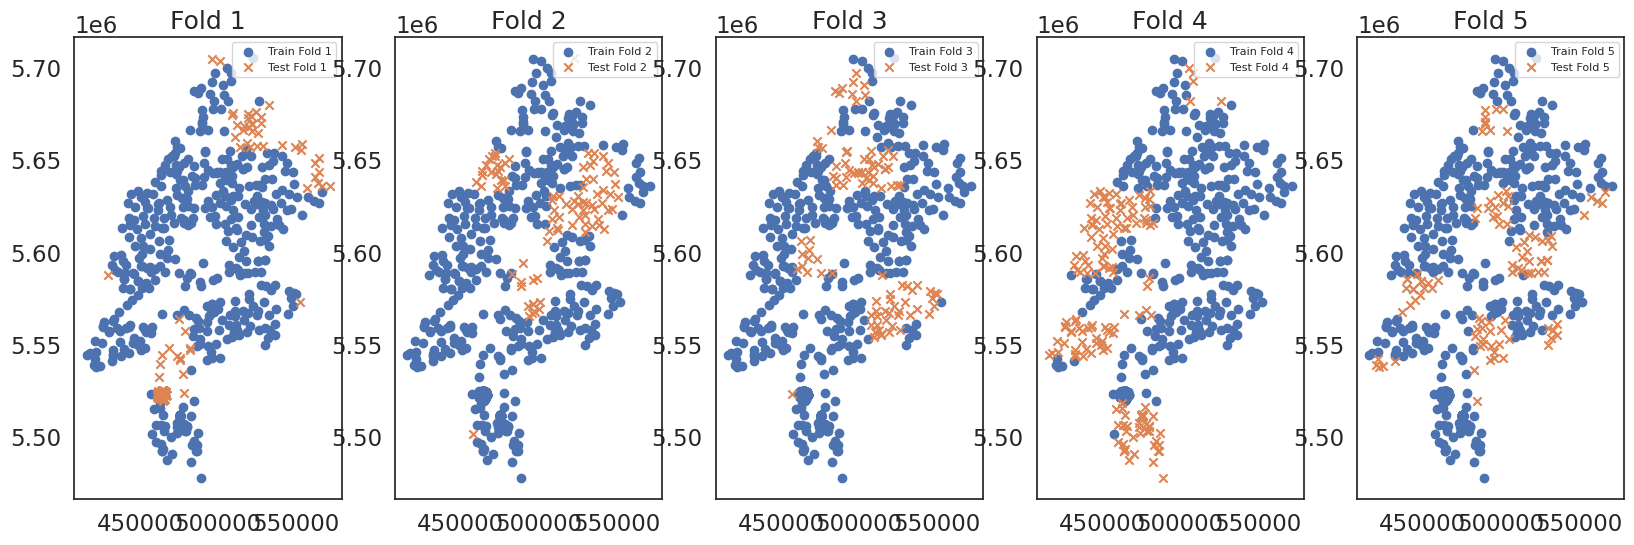

In [41]:
fig_folds, split_folds = get_splits_plot(data)

## GOOD RESULTS

In [42]:
import pandas as pd
from sklearn.inspection import permutation_importance

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import LeaveOneGroupOut, cross_validate
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,mean_absolute_percentage_error
from sklearn.metrics import mean_squared_log_error
import numpy as np


def relative_squared_error(true, pred):
    true_mean = np.mean(true)
    squared_error_num = np.sum(np.square(true - pred))
    squared_error_den = np.sum(np.square(true - true_mean))
    rse_loss = squared_error_num / squared_error_den
    return rse_loss

def quantile_loss(true, pred, gamma):
    val1 = gamma * np.abs(true - pred)
    val2 = (1-gamma) * np.abs(true - pred)
    q_loss = np.where(true >= pred, val1, val2)
    return q_loss

def r2_adj(response,true,pred):
    x= response
    r2=r2_score(true,pred)
    n = x.shape[0]
    p = x.shape[1]
    return 1-(1-r2)*(n-1)/(n-p-1)

### Random_Forest Modelling

### RF Regressor

In [43]:
def random_forest_regression_with_loo_cv(dataa, target_column, group_column):
    X = dataa.drop(columns=[target_column, group_column])
    y = dataa[target_column]
    groups = dataa[group_column]

    loo = LeaveOneGroupOut()
    model_main = RandomForestRegressor(n_estimators=500,max_depth=None, oob_score=True, random_state=24)
    metrics = {'RMSE': [],'R2 Score': [], 'MSE': [],
               'MAE': [], 'MAPE': [], 'RMSLE': [],
               'MBE': [], 'RRSE': [], 'R2 Adjusted': []}

    for train_index, test_index in loo.split(X, y, groups=groups):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        RF_regr = model_main.fit(X_train, y_train)
        y_pred = RF_regr.predict(X_train)

        rmse = np.sqrt(mean_squared_error(y_train, y_pred))
        mse = mean_squared_error(y_train, y_pred)
        mae = mean_absolute_error(y_train, y_pred)
        r2 = r2_score(y_train, y_pred)
        mape = mean_absolute_percentage_error(y_train, y_pred)
        RMSLE = mean_squared_log_error(y_train, y_pred, squared=False)
        MBE =  np.mean(y_train - y_pred)
        RRSE = np.sqrt(relative_squared_error(y_train, y_pred))
        r2_adju = r2_adj(X,y_train,y_pred)


        metrics['RMSE'].append(rmse)
        metrics['R2 Score'].append(r2)
        metrics['MAE'].append(mae)
        metrics['MSE'].append(mse)
        metrics['MAPE'].append(mape)
        metrics['RMSLE'].append(RMSLE)
        metrics['MBE'].append(MBE)
        metrics['RRSE'].append(RRSE)
        metrics['R2 Adjusted'].append(r2_adju)

    pred_table = pd.DataFrame({ "actual": y_train,
                               "predicted_prob": y_pred } )
    pred_table['Residual'] = pred_table['actual'] - pred_table['predicted_prob']

    metrics_df = pd.DataFrame(metrics)

    avg_metrics_score = pd.DataFrame(np.mean(metrics_df,axis=0), columns =['Score'])

    #avg_feature_importance =  pd.DataFrame(avg_feature_df, columns =['Score'])

    result_imp = permutation_importance(RF_regr, X_train, y_train,
                                    n_repeats=15,random_state=0)

    return RF_regr, avg_metrics_score, metrics_df, pred_table, result_imp #pred_table_0


def predict_on_separate_data(RF_regr, data):
    X = RF_regr.drop(columns=[target_column])
    return RF_regr.predict(X)

def get_RF_feature_importance(RF_regr, feature_names, result_imp):

    hlnug_imp = result_imp.importances_mean
    importance = RF_regr.feature_importances_
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    rf_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': hlnug_imp})
    Rf_importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
    Rf_imp_df = rf_imp_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
    return Rf_importance_df, Rf_imp_df


# Assuming you have your data in a DataFrame named 'your_data'
target_column = 'Rn_Poten'
group_column = 'grids_6k'



### Model results
def get_RF_model_results(input_dat,target_column, group_column):
  # Train the model using the function with LOO CV
  RF_regr, rf_avg_score, rf_metrics_df, rf_pred_table, perm_imp_rf = random_forest_regression_with_loo_cv(input_dat,
                                                               target_column, group_column)


  # Get feature importance
  feature_names = input_dat.drop(columns=[target_column, group_column]).columns.tolist()
  rf_feature_importance_df,Rf_imp_df = get_RF_feature_importance(RF_regr, feature_names, perm_imp_rf)

  return rf_avg_score, rf_metrics_df, rf_pred_table, RF_regr, rf_feature_importance_df, Rf_imp_df

In [44]:
from sklearn.inspection import PartialDependenceDisplay
def get_PD_plots(data, model, ncols=None, nrows=None):
    X = data.drop(columns=['grids_6k', 'Rn_Poten',
                           target_column, group_column])
    y = data[target_column]
    feature_list = list(X)
    fig , ax2 = plt.subplots(ncols=ncols, nrows=nrows,
                             figsize=(15, 15), sharey=False,
                            constrained_layout=True)
    #plt.figure(figsize=(15, 15))

    PartialDependenceDisplay.from_estimator(model, X, kind="average",
                                            features=feature_list, ax=ax2)
    #del_axis = fig.delaxes(ax2[8,1])
    plt.show()

In [45]:
def get_dataframe_top_10(feature_importance_unknown, main_dataframe):

  def get_top_10_predictors(feature_importance_unknown):
    '''
    This function creates a dataframe of the top 10 best predictors
    '''
    choosen_rows = feature_importance_unknown.iloc[:10]
    choosen_cols = pd.DataFrame(choosen_rows, index = choosen_rows['Feature'])
    series_choosen = choosen_cols.T
    series_cols=  list(series_choosen.columns.values)

    #index = len(series_cols)
    add_vars = ['grids_6k', 'Rn_Poten']
    series_columns = series_cols + add_vars

    return series_columns

  top_10_series = get_top_10_predictors(feature_importance_unknown)
  top_10_df = main_dataframe[top_10_series]
  return top_10_df

In [46]:
def get_dataframe_top_10_and_coords(feature_importance_table, main_dataframe):

  def get_top_10_predictors_and_coords(feature_importance_table):
    '''
    This function creates a dataframe of the top 10 best predictors
    '''
    choosen_rows = feature_importance_table.iloc[:10]
    choosen_cols = pd.DataFrame(choosen_rows, index = choosen_rows['Feature'])
    series_choosen = choosen_cols.T
    series_cols=  list(series_choosen.columns.values)

    #index = len(series_cols)
    add_vars = ['grids_6k', 'Rn_Poten', "Ostwert",
                "Nordwert","tl", "tr", "bl", "br", "c"]
    series_columns = series_cols + add_vars

    return series_columns

  top10_series = get_top_10_predictors_and_coords(feature_importance_table)
  good_results_top10_df = main_dataframe[top10_series]
  return good_results_top10_df

In [47]:
def get_val_scores(val_train, val_test, input__model):
  modeled_data = input__model.fit(val_train, val_test)
  pred_test = modeled_data.predict(val_train)

  pred_table_test = pd.DataFrame({ "actual": val_test,
                              "predicted_prob": pred_test } )
  pred_table_test['Residual'] = pred_table_test['actual'] - pred_table_test['predicted_prob']


  print(f'RMSE : {np.sqrt(mean_squared_error(val_test, pred_test))}')
  print(f'MSE : {mean_squared_error(val_test, pred_test)}')
  print(f'MAE: {mean_absolute_error(val_test, pred_test)}')
  print(f'r2: {r2_score(val_test, pred_test)}')
  print(f'MAPE: {mean_absolute_percentage_error(val_test, pred_test)}')
  print(f'RMSLE: {mean_squared_log_error(val_test, pred_test, squared=False)}')
  print(f'MBE : {np.mean(val_test - pred_test)}')
  print(f'RRSE : {np.sqrt(relative_squared_error(val_test, pred_test))}')
  print(f'r2_adju: {r2_adj(val_train,val_test,pred_test)}')

  return pred_table_test

#### Modelling with seasonal data and OHE Geounits

In [48]:
avg_score_rf0, metrics__rf0, pred_table_rf0, model_rf0, fimp_rf0, perm_imp_rf0 = get_RF_model_results(df_train_SFS,target_column, group_column)

In [49]:
metrics__rf0
avg_score_rf0

,Score
RMSE,11.270837
R2 Score,0.774445
MSE,127.194032
MAE,7.107413
MAPE,0.432963
RMSLE,0.405361
MBE,-0.253029
RRSE,0.473922
R2 Adjusted,0.764290


In [50]:
fimp_rf0
#pred_table_rf0
#permut_imp_rf0

,Feature,Importance
0,HC_KS_Weig,0.172296
1,Lin_Densit,0.065145
2,HC_WP_Ger_,0.044513
3,CP_PhH20_H,0.042466
4,Prec_JJA_3,0.039701
5,HP_FC_Hess,0.039147
6,CP_P_Hesse,0.033466
7,CP_CN_Hess,0.031809
8,DEM,0.030908
9,CP_CaC03_H,0.030113


In [51]:
fimp_rf0_index = fimp_rf0.set_index(['Feature'])
sum_geo_values_rf0 = fimp_rf0_index.loc[feature_groups_list].sum()
sum_geo_values_rf0

X_df_test_SFS=df_test_SFS.drop(group_column, axis=1)
y_df_test_SFS=df_test_SFS.Rn_Poten
pred_table_main_test_rf = get_val_scores(X_df_test_SFS, y_df_test_SFS, model_rf0)
#pred_table_rf3_test

RMSE : 4.080112215505731
MSE : 16.647315691119086
MAE: 0.5938662352264097
r2: 0.9876098268585408
MAPE: 0.012134649728324634
RMSLE: 0.035040599898453005
MBE : 0.30760447891022075
RRSE : 0.11131115461380851
r2_adju: 0.9849512067107783


In [52]:
avg_score_rf1, metrics__rf1, pred_table_rf1, model_rf1, fimp_rf1, permut_imp_rf1 = get_RF_model_results(df_multiannual_SFS,target_column, group_column)

In [53]:
avg_score_rf1

,Score
RMSE,11.396383
R2 Score,0.768926
MSE,130.008237
MAE,7.231896
MAPE,0.441598
RMSLE,0.410385
MBE,-0.233299
RRSE,0.479488
R2 Adjusted,0.761414


In [54]:
fimp_rf1
#permut_imp_rf1
#pred_table_rf1.shape

,Feature,Importance
0,HC_KS_Weig,0.182089
1,Lin_Densit,0.079712
2,HC_WP_Ger_,0.061507
3,CP_PhH20_H,0.050995
4,CP_P_Hesse,0.047902
5,CP_CN_Hess,0.046664
6,HP_FC_Hess,0.046280
7,CP_CaC03_H,0.044001
8,DEM,0.043324
9,AnnPreci_1,0.037490


In [55]:
feature_groups_list

['Carbononif',
 'Dev_low',
 'Dev_mid',
 'Dev_carb_p',
 'Dev_up',
 'Holocene',
 'Palaeo_met',
 'Paleo_igne',
 'Perm_low_m',
 'Perm_up_Ze',
 'Pleistocen',
 'Tert_fluv',
 'Tert_volc',
 'Trias_bund',
 'Trias_musc',
 'Trias_keup']

In [56]:
fimp_rf1_index = fimp_rf1.set_index(['Feature'])
sum_geo_values_rf1 = fimp_rf1_index.loc[feature_groups_list].sum()
sum_geo_values_rf1

Importance    0.060793
dtype: float64

In [57]:
def feature_groups(dataframe):

 # irrelevant_cols=['Rn_Poten','grids_4k']
  filtered_dataframe= dataframe.drop(columns=['Rn_Poten','grids_6k'], axis=1)
  ungrouped_features= filtered_dataframe.drop(columns=feature_groups_list, axis=1)
  ungrouped_features_tuple = [filtered_dataframe.columns.get_loc(col) \
                        for col in ungrouped_features]
  ungrouped_features_list = [[item] for item in ungrouped_features_tuple]

  grouped_features_tuple = [filtered_dataframe.columns.get_loc(col) \
                          for col in feature_groups_list]
  grouped_features_list = [grouped_features_tuple]
  feature_group_all = ungrouped_features_list + grouped_features_list

  #index_to_remove= [[item] for item in [dataframe.columns.get_loc(col) for col in irrelevant_cols]]
  #feature_group_= [item for item in feature_group_all if item not in index_to_remove]

  return feature_group_all

#### test data

In [58]:
df_test_multiannual_SFS
X_df_test_multiannual_SFS=df_test_multiannual_SFS.drop(group_column, axis=1)
y_test_multiannual_SFS=df_test_multiannual_SFS.Rn_Poten
pred_table_multi_test = get_val_scores(X_df_test_multiannual_SFS, y_test_multiannual_SFS, model_rf1)
#pred_table_rf3_test

RMSE : 3.884712093489828
MSE : 15.09098804930612
MAE: 0.5447122790649682
r2: 0.9887681618901273
MAPE: 0.009923311431622778
RMSLE: 0.029754108178610055
MBE : 0.29861560394047176
RRSE : 0.10598036662454402
r2_adju: 0.9870898412530199


In [59]:
pred_table_multi_test

,actual,predicted_prob,Residual
0,10.083600,10.129556,-0.045956
1,43.464761,43.528334,-0.063574
2,23.148511,23.134491,0.014020
3,12.215218,12.245149,-0.029931
4,39.983907,39.993119,-0.009212
...,...,...,...
296,9.724180,9.738689,-0.014509
297,9.525250,9.589877,-0.064627
298,31.950300,31.853636,0.096664
299,10.246700,10.276285,-0.029585


In [60]:
train_Scaled_multiannual.columns

Index(['Rn_Poten', 'AnnPreci_1', 'CP_CaC03_H', 'CP_CEC_Hes', 'CP_CN_Hess',
       'CP_N_Hesse', 'CP_P_Hesse', 'CP_PhH20_H', 'DEM', 'HC_FC_Weig',
       'HC_KS_Weig', 'HC_SWC_Wei', 'HC_WP_Ger_', 'HP_FC_Hess', 'Lin_Densit',
       'Pp_Clay_He', 'Pp_CoarseP', 'Pp_Sand_He', 'Pp_Silt_He', 'Prec_2020_',
       'SoilMois_9', 'TempAir_19', 'Uranium_ge', 'grids_6k', 'Carbononif',
       'Dev_low', 'Dev_mid', 'Dev_carb_p', 'Dev_up', 'Holocene', 'Palaeo_met',
       'Paleo_igne', 'Perm_low_m', 'Perm_up_Ze', 'Pleistocen', 'Tert_fluv',
       'Tert_volc', 'Trias_bund', 'Trias_musc', 'Trias_keup'],
      dtype='object')

#### drop NAN from scald

### Multi scaled

In [61]:
train_Scaled_multiannual

,Rn_Poten,AnnPreci_1,CP_CaC03_H,CP_CEC_Hes,CP_CN_Hess,CP_N_Hesse,CP_P_Hesse,CP_PhH20_H,DEM,HC_FC_Weig,...,Palaeo_met,Paleo_igne,Perm_low_m,Perm_up_Ze,Pleistocen,Tert_fluv,Tert_volc,Trias_bund,Trias_musc,Trias_keup
0,0.119981,0.919540,0.000000,0.376626,0.538871,0.444096,0.439216,0.653698,0.958124,0.865422,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.105442,0.658456,0.151464,0.534480,0.481528,0.384308,0.596466,0.799782,0.358459,0.961903,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.092715,0.881773,0.000000,0.322626,0.621897,0.366328,0.441479,0.678062,0.698492,0.768989,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.058049,0.711823,0.000000,0.435746,0.556497,0.479134,0.410967,0.690603,0.594640,0.865422,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.064111,0.874384,0.036654,0.565161,0.444681,0.543483,0.680145,0.848415,0.603015,0.794038,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1203,0.072213,0.483579,0.595185,0.337043,0.439457,0.210547,0.735346,0.935846,0.010050,0.147626,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1204,0.087614,0.483579,0.554895,0.511962,0.441957,0.238971,0.753220,0.905117,0.010050,0.147626,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1205,0.010296,0.498358,0.503281,0.382750,0.460627,0.197706,0.627116,0.960465,0.006700,0.244107,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1206,0.033002,0.498358,0.503281,0.382750,0.460627,0.197706,0.627116,0.960465,0.006700,0.244107,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [62]:
avg_score_rf2, metrics__rf2, pred_table_rf2, model_rf2, fimp_rf2, permut_imp_rf2 = get_RF_model_results(train_Scaled_multiannual,target_column, group_column)

In [63]:
fimp_rf2.head(10)
#permut_imp_rf3
#avg_score_rf3

,Feature,Importance
0,HC_KS_Weig,0.180590
1,Lin_Densit,0.076262
2,HC_WP_Ger_,0.061400
3,CP_PhH20_H,0.050042
4,CP_P_Hesse,0.048924
5,DEM,0.048064
6,HP_FC_Hess,0.047770
7,CP_CN_Hess,0.046720
8,CP_CaC03_H,0.042242
9,AnnPreci_1,0.039064


##### Testing on validation set

In [64]:
fimp_rf2_index = fimp_rf2.set_index(['Feature'])
sum_geo_values_rf2 = fimp_rf2_index.loc[feature_groups_list].sum()
sum_geo_values_rf2

Importance    0.063204
dtype: float64

In [65]:
train_Scaled_multiannual
X_test_Scaled_multiannual=test_Scaled_multiannual.drop(group_column, axis=1)
y_test_Scaled_multiannual=test_Scaled_multiannual.Rn_Poten
pred_table_scaled_test_rf2 = get_val_scores(X_test_Scaled_multiannual, y_test_Scaled_multiannual, model_rf2)
#pred_table_rf3_test

RMSE : 0.00928873235669425
MSE : 8.628054879429871e-05
MAE: 0.0012783984844995293
r2: 0.9893422201554013
MAPE: 28183260751.88561
RMSLE: 0.005119398998227403
MBE : 0.0007809373636783321
RRSE : 0.10323652379172149
r2_adju: 0.9877496783395417


In [66]:
pred_table_scaled_test_rf2

,actual,predicted_prob,Residual
0,0.019744,0.019900,-0.000156
1,0.101683,0.101788,-0.000105
2,0.051814,0.051781,0.000033
3,0.024977,0.025032,-0.000055
4,0.093139,0.093122,0.000017
...,...,...,...
296,0.018862,0.018892,-0.000030
297,0.018374,0.018539,-0.000165
298,0.073419,0.073146,0.000273
299,0.020145,0.020205,-0.000060


In [67]:
train_multiannual.columns

Index(['Rn_Poten', 'AnnPreci_1', 'CP_CaC03_H', 'CP_CEC_Hes', 'CP_CN_Hess',
       'CP_N_Hesse', 'CP_P_Hesse', 'CP_PhH20_H', 'DEM', 'HC_FC_Weig',
       'HC_KS_Weig', 'HC_SWC_Wei', 'HC_WP_Ger_', 'HP_FC_Hess', 'Lin_Densit',
       'Pp_Clay_He', 'Pp_CoarseP', 'Pp_Sand_He', 'Pp_Silt_He', 'Prec_2020_',
       'SoilMois_9', 'TempAir_19', 'Uranium_ge', 'grids_6k', 'grids_4k',
       'grids_10pa', 'Carbononif', 'Dev_low', 'Dev_mid', 'Dev_carb_p',
       'Dev_up', 'Holocene', 'Palaeo_met', 'Paleo_igne', 'Perm_low_m',
       'Perm_up_Ze', 'Pleistocen', 'Tert_fluv', 'Tert_volc', 'Trias_bund',
       'Trias_musc', 'Trias_keup'],
      dtype='object')

# RF FINAL

In [68]:
def random_forest_final(rf_final_predictors, target_column, group_column):
    X = rf_final_predictors.drop(columns=[target_column, group_column])
    y = rf_final_predictors[target_column]
    groups = rf_final_predictors[group_column]

    loo = LeaveOneGroupOut()
    estimating_model = RandomForestRegressor(n_estimators=100,max_depth=None)
    metrics = {'RMSE': [],'R2 Score': [], 'MSE': [],
               'MAE': [], 'MAPE': [], 'RMSLE': [],
               'MBE': [], 'RRSE': [], 'R2 Adjusted': []}

    for train_index, test_index in loo.split(X, y, groups=groups):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        output_model = estimating_model.fit(X_train, y_train)
        y_pred = output_model.predict(X_train)

        rmse = np.sqrt(mean_squared_error(y_train, y_pred))
        mse = mean_squared_error(y_train, y_pred)
        mae = mean_absolute_error(y_train, y_pred)
        r2 = r2_score(y_train, y_pred)
        mape = mean_absolute_percentage_error(y_train, y_pred)
        RMSLE = mean_squared_log_error(y_train, y_pred, squared=False)
        MBE =  np.mean(y_train - y_pred)
        RRSE = np.sqrt(relative_squared_error(y_train, y_pred))
        r2_adju = r2_adj(X,y_train,y_pred)


        metrics['RMSE'].append(rmse)
        metrics['R2 Score'].append(r2)
        metrics['MAE'].append(mae)
        metrics['MSE'].append(mse)
        metrics['MAPE'].append(mape)
        metrics['RMSLE'].append(RMSLE)
        metrics['MBE'].append(MBE)
        metrics['RRSE'].append(RRSE)
        metrics['R2 Adjusted'].append(r2_adju)

    pred_table = pd.DataFrame({ "actual": y_train,
                               "predicted_prob": y_pred } )
    pred_table['Residual'] = pred_table['actual'] - pred_table['predicted_prob']

    metrics_df = pd.DataFrame(metrics)

    avg_metrics_score = pd.DataFrame(np.mean(metrics_df,axis=0), columns =['Score'])

    #avg_feature_importance =  pd.DataFrame(avg_feature_df, columns =['Score'])

    result_imp = permutation_importance(output_model, X_train, y_train,
                                    n_repeats=15,random_state=0)

    return output_model, avg_metrics_score, metrics_df, pred_table, result_imp #pred_table_0


#def predict_on_separate_data(output_model, data):
#    X = output_model.drop(columns=[target_column])
#    return output_model.predict(X)

def get_RF_feature_importance(output_model, feature_names, result_imp):

    hlnug_imp = result_imp.importances_mean
    importance = output_model.feature_importances_
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    rf_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': hlnug_imp})
    Rf_importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
    Rf_imp_df = rf_imp_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
    return Rf_importance_df, Rf_imp_df


# Assuming you have your data in a DataFrame named 'your_data'
target_column = 'Rn_Poten'
group_column = 'grids_6k'



### Model results
def get_RFF_model_results(input_dat,target_column, group_column):
  # Train the model using the function with LOO CV
  RF_regr, rf_avg_score, rf_metrics_df, rf_pred_table, perm_imp_rf = random_forest_final(input_dat,
                                                               target_column, group_column)


  # Get feature importance
  feature_names = input_dat.drop(columns=[target_column, group_column]).columns.tolist()
  rf_feature_importance_df,Rf_imp_df = get_RF_feature_importance(RF_regr, feature_names, perm_imp_rf)

  return rf_avg_score, rf_metrics_df, rf_pred_table, RF_regr, rf_feature_importance_df, Rf_imp_df

In [69]:
df_multiannual_SFS.columns

Index(['Rn_Poten', 'AnnPreci_1', 'CP_CaC03_H', 'CP_CEC_Hes', 'CP_CN_Hess',
       'CP_N_Hesse', 'CP_P_Hesse', 'CP_PhH20_H', 'DEM', 'HC_FC_Weig',
       'HC_KS_Weig', 'HC_SWC_Wei', 'HC_WP_Ger_', 'HP_FC_Hess', 'Lin_Densit',
       'Pp_Clay_He', 'Pp_CoarseP', 'Pp_Sand_He', 'Pp_Silt_He', 'Prec_2020_',
       'SoilMois_9', 'TempAir_19', 'Uranium_ge', 'grids_6k', 'Carbononif',
       'Dev_low', 'Dev_mid', 'Dev_carb_p', 'Dev_up', 'Holocene', 'Palaeo_met',
       'Paleo_igne', 'Perm_low_m', 'Perm_up_Ze', 'Pleistocen', 'Tert_fluv',
       'Tert_volc', 'Trias_bund', 'Trias_musc', 'Trias_keup'],
      dtype='object')

In [70]:
test_pred_rf_0=df_multiannual_SFS.drop(columns=['AnnPreci_1', 'CP_CaC03_H', 'CP_CEC_Hes', 'CP_CN_Hess',
                                  'HC_KS_Weig', 'HC_SWC_Wei', 'HP_FC_Hess',
                                  'Pp_Clay_He', 'Pp_CoarseP', 'Pp_Sand_He', 'Prec_2020_',
                                  'SoilMois_9', 'TempAir_19', 'Uranium_ge'], axis=1)

In [71]:
rf_predictor_list = ['Lin_Densit','Pp_Silt_He','CP_PhH20_H','HC_WP_Ger_','CP_CEC_Hes', 'DEM',
                   'Pp_Sand_He','CP_N_Hesse', 'HC_FC_Weig','Carbononif', 'Dev_low', 'Dev_mid',
                   'Dev_carb_p','Dev_up', 'Holocene', 'Palaeo_met', 'Paleo_igne', 'Perm_low_m',
                   'Perm_up_Ze', 'Pleistocen', 'Tert_fluv', 'Tert_volc', 'Trias_bund',
                   'Trias_musc', 'Trias_keup', 'Rn_Poten','grids_6k']

rf_final_predictors = df_multiannual_SFS[rf_predictor_list]
rf_final_predictors_test = df_test_multiannual_SFS[rf_predictor_list]

In [72]:
avg_score_rff, metrics__rff, pred_table_rff, model_rff, fimp_rff, permut_imp_rff = get_RFF_model_results(rf_final_predictors,target_column, group_column)

In [73]:
avg_score_rff

,Score
RMSE,11.610018
R2 Score,0.760137
MSE,134.919366
MAE,7.396110
MAPE,0.458797
RMSLE,0.421055
MBE,-0.128582
RRSE,0.488507
R2 Adjusted,0.755063


In [74]:
fimp_rff

,Feature,Importance
0,HC_WP_Ger_,0.164950
1,CP_PhH20_H,0.126257
2,HC_FC_Weig,0.117737
3,Lin_Densit,0.108465
4,CP_N_Hesse,0.092630
5,DEM,0.082759
6,CP_CEC_Hes,0.068719
7,Pp_Silt_He,0.058688
8,Pp_Sand_He,0.055902
9,Tert_volc,0.049898


### Validation

In [75]:
fimp_rf3_index = fimp_rff.set_index(['Feature'])
sum_geo_values_rf3 = fimp_rf3_index.loc[feature_groups_list].sum()
print(sum_geo_values_rf3)

X_df_test_multiannual_SFS=df_test_multiannual_SFS.drop(group_column, axis=1)
y_test_multiannual_SFS=df_test_multiannual_SFS.Rn_Poten
pred_table_multi_test_rf3 = get_val_scores(X_df_test_multiannual_SFS, y_test_multiannual_SFS, model_rff)
#pred_table_rf3_test
pred_table_multi_test_rf3

Importance    0.123893
dtype: float64
RMSE : 3.795833447076828
MSE : 14.408351557947153
MAE: 0.5320119317101333
r2: 0.989276230847162
MAPE: 0.00829537907864815
RMSLE: 0.02287680851603189
MBE : 0.3196074299029514
RRSE : 0.10355563312943421
r2_adju: 0.9876738285599563


,actual,predicted_prob,Residual
0,10.083600,10.158256,-0.074656
1,43.464761,43.532355,-0.067594
2,23.148511,23.157715,-0.009204
3,12.215218,12.249713,-0.034494
4,39.983907,40.000032,-0.016125
...,...,...,...
296,9.724180,9.742117,-0.017937
297,9.525250,9.588214,-0.062964
298,31.950300,31.884708,0.065592
299,10.246700,10.279002,-0.032302


In [76]:
def get_PD_plots_2(data, model, ncols=None, nrows=None):
    X = data.drop(columns=['grids_6k', 'Rn_Poten',
                           target_column, group_column])
    y = data[target_column]
    feature_list = list(X)
    fig , ax2 = plt.subplots(ncols=ncols, nrows=nrows,
                             figsize=(15, 15), sharey=False,
                            constrained_layout=True)
    #plt.figure(figsize=(15, 15))

    PartialDependenceDisplay.from_estimator(model, X, kind="both",
                                            features=feature_list, ax=ax2)
    #del_axis = fig.delaxes(ax2[8,1])
    plt.show()
#get_PD_plots_2(Top_10rf_wo_coords, final_mod_rf4, ncols=2, nrows=5)

In [77]:
import seaborn as sns

In [78]:
## Partial Dependence plots
#get_PD_plots(Top_10rf_wo_coords, model_rf4, ncols=2, nrows=5)

#### Top 10 predictors and coordinates

# SHAP Explainability

### In Search of Model explainability

In [79]:
import shap

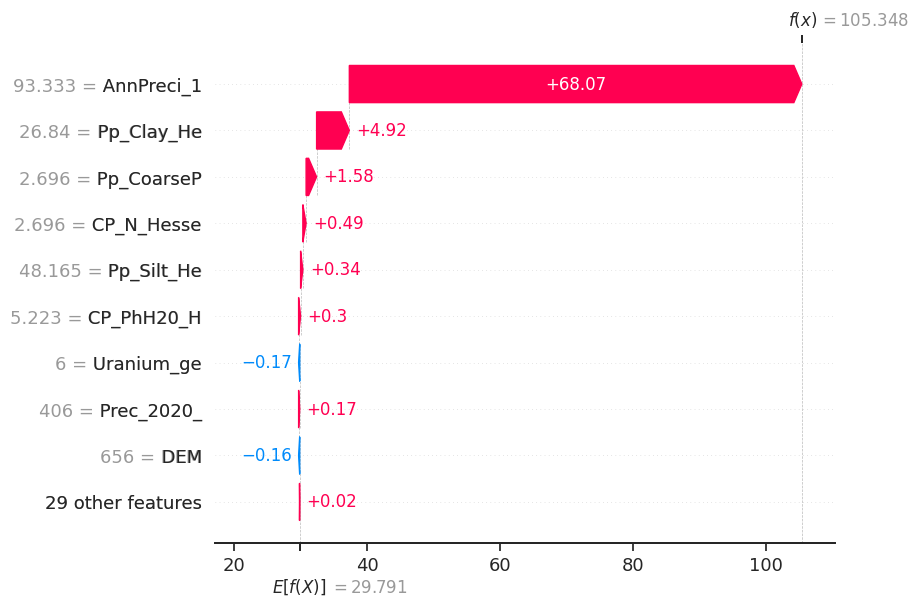

In [80]:
RF_explainer = shap.Explainer(model_rf1)
shap_train = df_multiannual_SFS.drop(columns=['Rn_Poten',
                                'grids_6k'],axis = 1)
rf_shap_values = RF_explainer(shap_train)

# visualize the first prediction's explanation
shap.plots.waterfall(rf_shap_values[0])

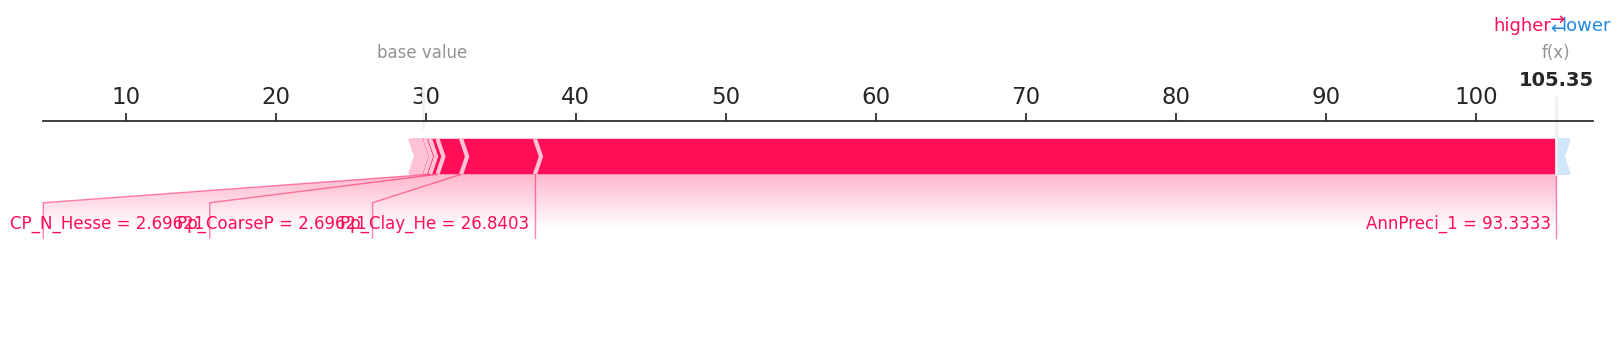

In [81]:
rf_force_plot = shap.plots.force(rf_shap_values[0], matplotlib=True)
rf_force_plot

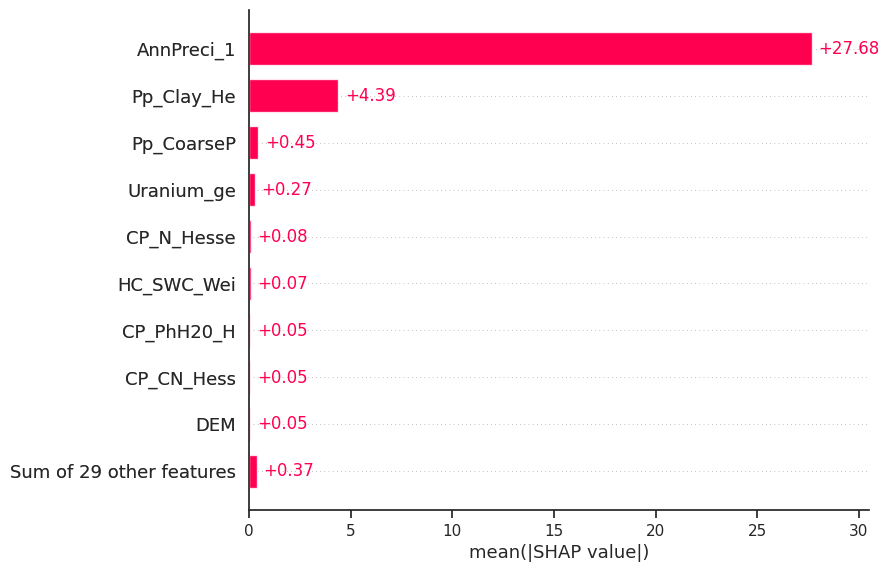

In [82]:
rf_bar_plot_shap = shap.plots.bar(rf_shap_values)
rf_bar_plot_shap

In [83]:
rf_feat=list(shap_train)

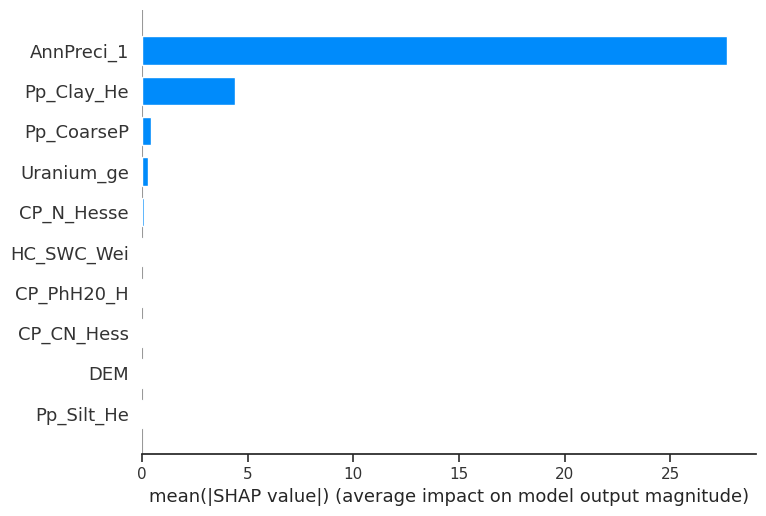

In [84]:
rf_feat=list(shap_train)
shap.summary_plot(
    rf_shap_values, features=shap_train,
    feature_names=rf_feat, plot_type="bar",color_bar_label='Feature value',
    max_display=10)

In [85]:
def get_shap_plots(data,model):
  dataframe=data.drop(columns=['Rn_Poten',
                                'grids_6k'],axis = 1)
  explainer = shap.Explainer(model)
  shap_values = explainer(dataframe)
  waterfall_plot = shap.plots.waterfall(shap_values[0])

  #visualize the first prediction's explanation with a force plot
  force_plot = shap.plots.force(shap_values[0], matplotlib=True)

  bee_plot = shap.plots.beeswarm(shap_values)

  bar_plot_shap = shap.plots.bar(shap_values)

  scatter_plot_Geology = shap.plots.scatter(shap_values[:, "Geology_Ra"], color=shap_values)


  return shap_values, waterfall_plot, bar_plot_shap, force_plot, bee_plot, scatter_plot_Geology

In [86]:
#shap_values_rf, waterfall_plot_rf, bar_plot_shap_rf, force_plot_rf, bee_plot_rf, scatter_plot_Geology_rf = get_shap_plots(Top_10rf_wo_coords,final_mod_rf1)

## Model 2: SVR Regressor

In [87]:
from sklearn.svm import SVR
from sklearn.model_selection import GroupKFold, cross_val_predict, GridSearchCV
param = {'kernel' : ('rbf', 'sigmoid'),
         'C' : [1,60,300],'degree' : [3,8],'coef0' : [0.01,10,0.5],
         'gamma' : ('auto','scale')}
#modelsvr = SVR()
#modelsvr = SVR(kernel='rbf', C=300.0, epsilon=0.1, gamma = 0.05)


In [88]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.feature_selection import f_regression


### Original SVR

In [89]:
#def gamma_value_for_SVR(df_train_SFS):#
#  number_of_featuresz =  df_train_SFS.shape[1]
#  features_variance = df_train_SFS.values.var()
#  gamma = 1/(number_of_featuresz * features_variance)
#  print('gamma:', gamma)
#gamma_value_for_SVR(df_train_SFS)

In [90]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.feature_selection import f_regression



def GridSearchCV_params(df, target_column, group_column, Estimator):
    X = df.drop(columns=[target_column, group_column])
    y = df[target_column]
    groups = df[group_column].values
    #model_raf = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)
    #modelsvr = SVR(kernel='rbf', C=300.0, epsilon=0.1, gamma = 0.05)
    loo = LeaveOneGroupOut()



    metrics = {'RMSE': [],'R2 Score': [], 'MSE': [],
                'MAE': [], 'R2 Adjusted': []}
    feature_importance = []
    for i, (train_index, test_index) in enumerate (loo.split(X, y, groups=groups)):
        i+=1
        print(f"------Iteration: {i}--------")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        start_time = timer(None)


        Estimator.fit(X_train, y_train)
        y_pred = Estimator.predict(X_train)

        print("Best Parameters: ", Estimator.best_params_)
        print("Best Score: ", Estimator.best_score_)
        timer(start_time)

        importance = f_regression(X_train, y_train)[0]  # Extract feature importance using f_regression
        feature_importance.append(importance)

        rmse = np.sqrt(mean_squared_error(y_train, y_pred))
        mse = mean_squared_error(y_train, y_pred)
        mae = mean_absolute_error(y_train, y_pred)
        r2 = r2_score(y_train, y_pred)
        r2_adju = r2_adj(X,y_train,y_pred)

        metrics['RMSE'].append(rmse)
        metrics['R2 Score'].append(r2)
        metrics['MAE'].append(mae)
        metrics['MSE'].append(mse)
        metrics['R2 Adjusted'].append(r2_adju)

    best_estimator = Estimator.best_params_

    metrics_df = pd.DataFrame(metrics)

    avg_metrics_score = pd.DataFrame(np.mean(metrics_df,axis=0), columns =['Score'])

    # Calculate mean feature importance across all folds
    mean_importance = np.mean(feature_importance, axis=0)

    # Create a DataFrame to store feature importance
    importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': mean_importance})
    importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

    return importance_df, metrics_df, avg_metrics_score, best_estimator


In [91]:
#svr_ =SVR(kernel='rbf')

#param_svr={'C': [0.1, 1, 100, 300, 1000],
#            'epsilon': [0.0001, 0.0005, 0.001, 0.005,
#                        0.01, 0.05, 0.1, 0.5, 1, 5, 10],
#            'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]}
#svr_grid = GridSearchCV(svr_,param_svr, scoring='neg_mean_squared_error',
#                        verbose=0, n_jobs=-1)

In [92]:
#importance_svr_grid, metrics_svr_grid, avg_metrics_score_svr_grid, best_estimator_svr_grid = GridSearchCV_params(df_multiannual_SFS, target_column, group_column, svr_grid)
#

In [93]:
#best_estimator_svr_grid

In [94]:
from sklearn.svm import SVR
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.feature_selection import f_regression

def svr_leave_one_group_out(df, target_column, group_column):
    X = df.drop(columns=[target_column, group_column])
    y = df[target_column]
    groups = df[group_column].values

    #modelsvr_ = SVR(kernel='rbf', C=100.0, gamma=0.01)
    loo = LeaveOneGroupOut()

    #modelsvr_ = SVR(kernel='rbf',C= 250, epsilon= 1, gamma= 0.01)
    model__svr = SVR(kernel='rbf', C=300.0, epsilon=0.1, gamma = 0.05)

    metrics = {'RMSE': [],'R2 Score': [], 'MSE': [],
                  'MAE': [], 'MAPE': [], 'RMSLE': [],
                  'MBE': [], 'RRSE': [], 'R2 Adjusted': []}

    feature_importance = []
    for train_index, test_index in loo.split(X, y, groups=groups):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]


        modell_svr = model__svr.fit(X_train, y_train)
        y_pred = modell_svr.predict(X_train)

        modell_svr__ = model__svr.fit(X_test, y_test)
        y_predt = modell_svr__.predict(X_test)

        importance = f_regression(X_train, y_train)[0]  # Extract feature importance using f_regression
        feature_importance.append(importance)

        rmse = np.sqrt(mean_squared_error(y_train, y_pred))
        mse = mean_squared_error(y_train, y_pred)
        mae = mean_absolute_error(y_train, y_pred)
        r2 = r2_score(y_train, y_pred)
        mape = mean_absolute_percentage_error(y_train, y_pred)
        RMSLE = mean_squared_log_error(y_train, y_pred, squared=False)
        MBE =  np.mean(y_train - y_pred)
        RRSE = np.sqrt(relative_squared_error(y_train, y_pred))
        r2_adju = r2_adj(X,y_train,y_pred)

        metrics['RMSE'].append(rmse)
        metrics['R2 Score'].append(r2)
        metrics['MAE'].append(mae)
        metrics['MSE'].append(mse)
        metrics['MAPE'].append(mape)
        metrics['RMSLE'].append(RMSLE)
        metrics['MBE'].append(MBE)
        metrics['RRSE'].append(RRSE)
        metrics['R2 Adjusted'].append(r2_adju)

    pred_table = pd.DataFrame({ "actual": y_train,
                               "predicted_prob": y_pred } )
    pred_table['Residual'] = pred_table['actual'] - pred_table['predicted_prob']
    #pred_table_0 = pd.DataFrame({ "actual": y_test,
    #                           "predicted_prob": y_predt } )
    #pred_table_0['Residual'] = pred_table_0['actual'] - pred_table_0['predicted_prob']

    metrics_df = pd.DataFrame(metrics)

    avg_metrics_score = pd.DataFrame(np.mean(metrics_df,axis=0), columns =['Score'])

    # Calculate mean feature importance across all folds
    mean_importance = np.mean(feature_importance, axis=0)

    # Create a DataFrame to store feature importance
    importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': mean_importance})
    importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

    return modell_svr, pred_table, importance_df, metrics_df, avg_metrics_score



In [95]:
model_svr0, pred_table_svr0, importance_df_svr0, metrics_df_svr0, avg_metrics_score_svr0= svr_leave_one_group_out(df_train_SFS,
                                                                                                                   target_column, group_column)

In [96]:
avg_metrics_score_svr0

,Score
RMSE,8.549883
R2 Score,0.857283
MSE,75.936735
MAE,4.218387
MAPE,0.221467
RMSLE,0.307067
MBE,0.622426
RRSE,0.366158
R2 Adjusted,0.850857


In [97]:
importance_df_svr0

,Feature,Importance
0,CP_N_Hesse,27.213935
1,Pp_CoarseP,27.213935
2,HC_WP_Ger_,9.187259
3,Dev_carb_p,8.877769
4,Pleistocen,7.298862
5,Trias_bund,7.189994
6,CP_CaC03_H,7.014222
7,Pp_Clay_He,4.285924
8,Trias_musc,4.206704
9,Dev_low,4.011519


In [98]:
fimp_svr0_index = importance_df_svr0.set_index(['Feature'])
sum_geo_values_svr0 = fimp_svr0_index.loc[feature_groups_list].sum()
print(sum_geo_values_svr0)

X_df_test_SFS=df_test_SFS.drop(group_column, axis=1)
y_df_test_SFS=df_test_SFS.Rn_Poten
pred_table_main_test_svr = get_val_scores(X_df_test_SFS, y_df_test_SFS, model_svr0)
#pred_table_rf3_test
#pred_table_main_test_svr

Importance    42.913818
dtype: float64
RMSE : 4.553003087232896
MSE : 20.72983711235228
MAE: 0.370360596844269
r2: 0.9845713101269947
MAPE: 0.006716793165722463
RMSLE: 0.014121468600185705
MBE : 0.2409022566266129
RRSE : 0.12421227746485161
r2_adju: 0.9812607005591029


In [99]:
pred_table_main_test_svr

,actual,predicted_prob,Residual
0,10.083600,10.183130,-0.099530
1,43.464761,43.364795,0.099966
2,23.148511,23.249012,-0.100501
3,12.215218,12.315347,-0.100128
4,39.983907,39.883610,0.100296
...,...,...,...
296,9.724180,9.824389,-0.100209
297,9.525250,9.625222,-0.099972
298,31.950300,31.850403,0.099897
299,10.246700,10.346857,-0.100157


#### Multiannual

In [100]:
model_svr1, pred_table_svr1, importance_df_svr1, metrics_df_svr1, avg_metrics_score_svr1= svr_leave_one_group_out(df_multiannual_SFS,
                                                                                                                   target_column, group_column)

In [101]:
avg_metrics_score_svr1

,Score
RMSE,8.665747
R2 Score,0.853164
MSE,78.079517
MAE,4.337671
MAPE,0.228609
RMSLE,0.312394
MBE,0.591598
RRSE,0.371207
R2 Adjusted,0.848390


In [102]:
importance_df_svr1.head(10)

,Feature,Importance
0,Pp_CoarseP,27.213935
1,CP_N_Hesse,27.213935
2,HC_WP_Ger_,9.187259
3,Dev_carb_p,8.877769
4,Pleistocen,7.298862
5,Trias_bund,7.189994
6,CP_CaC03_H,7.014222
7,Pp_Clay_He,4.285924
8,Trias_musc,4.206704
9,Dev_low,4.011519


In [103]:
df_test_multiannual_SFS

,Rn_Poten,AnnPreci_1,CP_CaC03_H,CP_CEC_Hes,CP_CN_Hess,CP_N_Hesse,CP_P_Hesse,CP_PhH20_H,DEM,HC_FC_Weig,...,Palaeo_met,Paleo_igne,Perm_low_m,Perm_up_Ze,Pleistocen,Tert_fluv,Tert_volc,Trias_bund,Trias_musc,Trias_keup
0,10.083600,57.5000,0.0000,9.28751,10.48420,1.55973,38.8946,6.07239,182,29.0255,...,0,0,0,0,0,0,0,0,0,0
1,43.464761,64.1667,20.4359,16.76740,11.97380,1.95452,45.0563,6.25560,217,30.0380,...,0,0,0,0,0,0,0,0,0,0
2,23.148511,64.1667,20.4359,16.76740,11.97380,1.95452,45.0563,6.25560,233,30.0380,...,0,0,0,0,0,0,0,0,0,0
3,12.215218,64.1667,20.4359,16.76740,11.97380,1.95452,45.0563,6.25560,233,30.0380,...,0,0,0,0,0,0,0,0,0,0
4,39.983907,64.1667,20.4359,16.76740,11.97380,1.95452,45.0563,6.25560,217,30.0380,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,9.724180,53.5833,8.9793,14.10450,9.05821,2.12045,44.7284,6.73537,252,32.9880,...,0,0,0,0,0,0,0,1,0,0
297,9.525250,58.5000,0.0000,8.70555,20.23070,2.69069,16.6532,3.89700,403,30.1880,...,0,0,0,0,0,0,0,1,0,0
298,31.950300,62.0833,0.0000,0.00000,0.00000,0.00000,0.0000,0.00000,347,32.9880,...,0,0,0,0,0,0,0,0,1,0
299,10.246700,0.0000,0.0000,8.60843,12.08470,2.84808,39.4043,5.48905,393,32.9880,...,0,0,0,0,0,0,0,0,1,0


In [104]:
fimp_svr1_index = importance_df_svr1.set_index(['Feature'])
sum_geo_values_svr1 = fimp_svr1_index.loc[feature_groups_list].sum()
print(sum_geo_values_svr1)


#df_test_multiannual_SFS
X_test_multiannual=df_test_multiannual_SFS.drop(group_column, axis=1)
y_test_multiannual=df_test_multiannual_SFS.Rn_Poten
pred_table_scaled_test_svr1 = get_val_scores(X_test_multiannual, y_test_multiannual, model_svr1)
#pred_table_rf3_test
pred_table_scaled_test_svr1

Importance    42.913818
dtype: float64
RMSE : 4.547570236931976
MSE : 20.680395059829543
MAE: 0.3695758619172397
r2: 0.984608108587635
MAPE: 0.006693846325676988
RMSLE: 0.014101110419329443
MBE : 0.23986935063400544
RRSE : 0.12406406172766155
r2_adju: 0.9823081707903851


,actual,predicted_prob,Residual
0,10.083600,10.183354,-0.099754
1,43.464761,43.364890,0.099871
2,23.148511,23.248218,-0.099707
3,12.215218,12.315144,-0.099926
4,39.983907,39.883939,0.099968
...,...,...,...
296,9.724180,9.824289,-0.100109
297,9.525250,9.624957,-0.099707
298,31.950300,31.850034,0.100266
299,10.246700,10.346616,-0.099916


### Model without seasonal and coords

In [105]:
#pred_table_0svr2, model_svr2, pred_table_svr2, importance_df_svr2, metrics_df_svr2, avg_metrics_score_svr2= svr_leave_one_group_out(train_Scaled_multiannual,
#                                                                                                                   target_column, group_column)

In [106]:
#pred_table_svr2

In [107]:
#avg_metrics_score_svr2

In [108]:
#importance_df_svr2
#avg_metrics_score_svr2

In [109]:
#df_test_multiannual_SFS
#X_df_test_multiannual_SFS=df_test_multiannual_SFS.drop(group_column, axis=1)
#y_test_multiannual_SFS=df_test_multiannual_SFS.Rn_Poten
#pred_table_svr2_test = get_val_scores(X_test_Scaled_multiannual, y_test_Scaled_multiannual, model_svr2)
#pred_table_rf3_test

#### score on val set

# SVR Final

In [110]:
svr_predictors_list= ['Pp_CoarseP','CP_CN_Hess','HC_WP_Ger_','CP_CaC03_H','Pp_Clay_He',
                     'Lin_Densit','CP_P_Hesse','CP_N_Hesse','AnnPreci_1', 'Carbononif',
                     'Dev_low', 'Dev_mid', 'Dev_carb_p','Dev_up', 'Holocene', 'Palaeo_met',
                     'Paleo_igne', 'Perm_low_m', 'Perm_up_Ze', 'Pleistocen', 'Tert_fluv',
                     'Tert_volc', 'Trias_bund','Trias_musc', 'Trias_keup','Rn_Poten','grids_6k']
svr_final_predictors = df_multiannual_SFS[svr_predictors_list]
svr_final_predictors_test = df_test_multiannual_SFS[svr_predictors_list]

In [111]:
model_svrf, pred_table_svrf, importance_df_svrf, metrics_df_svrf, avg_metrics_score_svrf= svr_leave_one_group_out(svr_final_predictors,
                                                                                                                   target_column, group_column)

In [112]:
importance_df_svrf

,Feature,Importance
0,Pp_CoarseP,27.213935
1,CP_N_Hesse,27.213935
2,HC_WP_Ger_,9.187259
3,Dev_carb_p,8.877769
4,Pleistocen,7.298862
5,Trias_bund,7.189994
6,CP_CaC03_H,7.014222
7,Pp_Clay_He,4.285924
8,Trias_musc,4.206704
9,Dev_low,4.011519


In [113]:
avg_metrics_score_svrf

,Score
RMSE,9.238241
R2 Score,0.834881
MSE,88.162644
MAE,4.793264
MAPE,0.250737
RMSLE,0.332415
MBE,0.804220
RRSE,0.395098
R2 Adjusted,0.831389


#### Validation final

In [114]:
fimp_svr3_index = importance_df_svrf.set_index(['Feature'])
sum_geo_values_svr3 = fimp_svr3_index.loc[feature_groups_list].sum()
print(sum_geo_values_svr3)


pred_table_test_svr3 = get_val_scores(X_test_multiannual, y_test_multiannual, model_svrf)
#pred_table_rf3_test
pred_table_test_svr3

Importance    42.913818
dtype: float64
RMSE : 4.547570236931976
MSE : 20.680395059829543
MAE: 0.3695758619172397
r2: 0.984608108587635
MAPE: 0.006693846325676988
RMSLE: 0.014101110419329443
MBE : 0.23986935063400544
RRSE : 0.12406406172766155
r2_adju: 0.9823081707903851


,actual,predicted_prob,Residual
0,10.083600,10.183354,-0.099754
1,43.464761,43.364890,0.099871
2,23.148511,23.248218,-0.099707
3,12.215218,12.315144,-0.099926
4,39.983907,39.883939,0.099968
...,...,...,...
296,9.724180,9.824289,-0.100109
297,9.525250,9.624957,-0.099707
298,31.950300,31.850034,0.100266
299,10.246700,10.346616,-0.099916


#### Top 10 data

### PARTIAL DEPENDENCE PLOTS SVR Top_10

In [115]:
## Partial Dependence plots
#get_PD_plots(Top_10svm_wo_coords, model_svr4, ncols=2, nrows=5)

### SVR SHAP explainer

In [116]:
#Top_10svm_wo_coords_test.columns

In [117]:
#shap.KernelExplainer(model.predict)
#svr_shap_train = Top_10svm_wo_coords.drop(columns=['Rn_Poten',
#                                                   'grids_4k'],axis = 1)
#svr_explainer = shap.Explainer(model_svr4,masker=shap.maskers.Impute(data=svr_shap_train),
#                                     feature_names=svr_shap_train.columns)#
#
#svr_shap_values = svr_explainer(svr_shap_train)
#svr_shap_values

# use Kernel SHAP to explain test set predictions
#svr_explainer = shap.KernelExplainer(model_svr4.predict,
 #                                    svr_shap_train, link="logit")
#svr_shap_values = svr_explainer.shap_values(Top_10svm_wo_coords_test, nsamples=100)

# plot the SHAP values for the Setosa output of the first instance
#svr_shap_force = shap.force_plot(svr_explainer.expected_value[0], svr_shap_values[0][0,:],
#                Top_10svm_wo_coords_test.iloc[0,:], link="logit")
#svr_shap_force

In [118]:
# explain all the predictions in the test set
#svr_explainer = shap.KernelExplainer(model_svr4.predict, svr_shap_train)
#svr_shap_values = svr_explainer.shap_values(Top_10svm_wo_coords_test, nsamples=50)

In [119]:
#feat_names = list(Top_10svm_wo_coords_test)

#shap.summary_plot(
#    svr_shap_values, features=Top_10svm_wo_coords_test,
 #   feature_names=feat_names, plot_type="bar",color_bar_label='Feature value',
  #  max_display=10)

In [120]:
#exp = shap.Explanation(svr_explainer[:,:,6], svr_explainer.base_values[:,6],
#                       Top_10svm_wo_coords_test, feature_names=None)
#shap.plots._waterfall.waterfall_legacy(svr_explainer.expected_value,
 #                                      svr_shap_values[0], feature_names=feat_names)
#idx = 7 # datapoint to explain
#shap.waterfall_plot(svr_explainer.expected_value[0], svr_shap_values[0], Top_10svm_wo_coords_test)

## MARS (Multivariate adaptive Regression Splines)

In [121]:
#!pip install git+https://github.com/scikit-learn-contrib/py-earth@v0.2dev

In [122]:
#from sklearn.model_selection import GroupKFold
#from pyearth import*
#from sklearn.metrics import mean_squared_error
#import numpy as np

def mars_with_logo_cv(data, target_column, group_column):
    # 3. MARS Regression
    #mars = Earth  # Initialize MARS model
    # Train the model
    loo = LeaveOneGroupOut()

    metrics = {'RMSE': [],'R2 Score': [], 'MSE': [],
                  'MAE': [], 'MAPE': [], 'RMSLE': [],
                  'MBE': [], 'RRSE': [], 'QL': []}

    feature_importance = []
    for train_index, test_index in loo.split(X, y, groups=groups):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        mars.fit(X_train, y_train)
        y_pred = mars.predict(X_train)

        importance = f_regression(X_test, y_test)[0]  # Extract feature importance using f_regression
        feature_importance.append(importance)

        rmse = np.sqrt(mean_squared_error(y_train, y_pred))
        mse = mean_squared_error(y_train, y_pred)
        mae = mean_absolute_error(y_train, y_pred)
        r2 = r2_score(y_train, y_pred)
        mape = mean_absolute_percentage_error(y_train, y_pred)
        RMSLE = mean_squared_log_error(y_train, y_pred, squared=False)
        MBE =  np.mean(y_train - y_pred)
        RRSE = np.sqrt(relative_squared_error(y_train, y_pred))
        QL = quantile_loss(y_train, y_pred, 0.9)

        metrics['RMSE'].append(rmse)
        metrics['R2 Score'].append(r2)
        metrics['MAE'].append(mae)
        metrics['MSE'].append(mse)
        metrics['MAPE'].append(mape)
        metrics['RMSLE'].append(RMSLE)
        metrics['MBE'].append(MBE)
        metrics['RRSE'].append(RRSE)
        metrics['QL'].append(QL)


    metrics_df = pd.DataFrame(metrics)

    avg_metrics_score = pd.DataFrame(np.mean(metrics_df,axis=0), columns =['Score'])

    # Calculate mean feature importance across all folds
    mean_importance = np.mean(feature_importance, axis=0)

    # Create a DataFrame to store feature importance
    importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': mean_importance})
    importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

    return model, importance_df, metrics_df, avg_metrics_score
# 5. Prediction on Raster Data
# Assuming model is already trained
#raster_predictions = model.predict(X_raster)


In [123]:
#model_mars, importance_df_mars, metrics_df_mars, avg_metrics_score_mars = mars_with_logo_cv(df_train_wo_seasonal, target_column, group_column)

## GBM (Gradient Boosting Machines)

In [124]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Assuming point_data is your DataFrame with features and target
# Assuming groups are available for GroupKFold (replace with your group column)
def gbm_with_logo(datah, target_column, group_column):

    X = datah.drop(columns=[target_column, group_column])
    y = datah[target_column]
    groups = datah[group_column].values

    # Initialize GBM model
    gbm = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05)
    #gbm__ = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)
    loo = LeaveOneGroupOut()

    metrics = {'RMSE': [],'R2 Score': [], 'MSE': [],
                  'MAE': [], 'MAPE': [], 'RMSLE': [],
                  'MBE': [], 'RRSE': [], 'QL': []}

    gbm_feature_importance = []
    for train_index, test_index in loo.split(X, y, groups=groups):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        gbmr_ = gbm.fit(X_train, y_train)
        y_pred = gbmr_.predict(X_train)

        #gbmr__ = gbm.fit(X_test, y_test)
        #y_predt = gbmr__.predict(X_test)

        gbm_importance = f_regression(X_test, y_test)[0]  # Extract feature importance using f_regression
        gbm_feature_importance.append(gbm_importance)

        rmse = np.sqrt(mean_squared_error(y_train, y_pred))
        mse = mean_squared_error(y_train, y_pred)
        mae = mean_absolute_error(y_train, y_pred)
        r2 = r2_score(y_train, y_pred)
        mape = mean_absolute_percentage_error(y_train, y_pred)
        RMSLE = mean_squared_log_error(y_train, y_pred, squared=False)
        MBE =  np.mean(y_train - y_pred)
        RRSE = np.sqrt(relative_squared_error(y_train, y_pred))
        QL = quantile_loss(y_train, y_pred, 0.9)

        metrics['RMSE'].append(rmse)
        metrics['R2 Score'].append(r2)
        metrics['MAE'].append(mae)
        metrics['MSE'].append(mse)
        metrics['MAPE'].append(mape)
        metrics['RMSLE'].append(RMSLE)
        metrics['MBE'].append(MBE)
        metrics['RRSE'].append(RRSE)
        metrics['QL'].append(QL)


    gbm_pred_table = pd.DataFrame({ "actual": y_train,
                                  "predicted_prob": y_pred } )
    gbm_pred_table['Residual'] = gbm_pred_table['actual'] - gbm_pred_table['predicted_prob']
    #gbm_pred_table0 = pd.DataFrame({ "actual": y_test,
    #                                  "predicted_prob": y_predt } )
    #gbm_pred_table0['Residual'] = gbm_pred_table0['actual'] - gbm_pred_table0['predicted_prob']

    gbm_metrics_df = pd.DataFrame(metrics)

    gbm_avg_metrics_score = pd.DataFrame(np.mean(gbm_metrics_df,axis=0), columns =['Score'])

    # Calculate mean feature importance across all folds
    gbm_mean_importance = np.mean(gbm_feature_importance, axis=0)

    # Create a DataFrame to store feature importance
    gbm__importance_unsort = pd.DataFrame({'Feature': X.columns, 'Importance': gbm_mean_importance})
    gbm_importance_df = gbm__importance_unsort.sort_values(by='Importance', ascending=False).reset_index(drop=True)

    return gbmr_, gbm_pred_table, gbm_importance_df, gbm_metrics_df, gbm_avg_metrics_score
# Make predictions on raster data
# Prepare raster data and transform it into the required format
#raster_predictions = gbm.predict(raster_data)


### All data with Geology units

In [125]:
model_gbm0 , pred_table_gbm0, importance_df_gbm0 , metrics_df_gbm0 , avg_metrics_score_gbm0 = gbm_with_logo(df_train_SFS, target_column, group_column)

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.


In [126]:
avg_metrics_score_gbm0

,Score
RMSE,8.396864e+00
R2 Score,8.618034e-01
MSE,7.348044e+01
MAE,5.067116e+00
MAPE,3.029310e-01
RMSLE,3.296627e-01
MBE,5.209977e-16
RRSE,3.597772e-01


In [127]:
importance_df_gbm0

,Feature,Importance
0,Trias_musc,30.338127
1,CP_N_Hesse,12.903652
2,Pp_CoarseP,12.903652
3,CP_CaC03_H,12.852511
4,HC_WP_Ger_,9.308983
5,Pp_Clay_He,7.911615
6,CP_CN_Hess,3.728577
7,Tert_fluv,3.535181
8,Pleistocen,2.963322
9,Holocene,2.956844


#### Validation

In [128]:
fimp_gbm0_index = importance_df_gbm0.set_index(['Feature'])
sum_geo_values_gbm0 = fimp_gbm0_index.loc[feature_groups_list].sum()
print(sum_geo_values_gbm0)


pred_table_main_test_gbm0 = get_val_scores(X_df_test_SFS, y_df_test_SFS, model_gbm0)
#pred_table_rf3_test
#pred_table_main_test_svr

Importance    47.693623
dtype: float64
RMSE : 0.018542811934445624
MSE : 0.00034383587443621903
MAE: 0.012081476675663956
r2: 0.9999997440917145
MAPE: 0.000638553908526013
RMSLE: 0.0009618938933285733
MBE : 8.896537991348431e-16
RRSE : 0.0005058737841488544
r2_adju: 0.9999996891802201


### All data with coords

In [129]:
model_gbm1 , pred_table_gbm1, importance_df_gbm1 , metrics_df_gbm1 , avg_metrics_score_gbm1 = gbm_with_logo(df_multiannual_SFS, target_column, group_column)

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.


In [130]:
avg_metrics_score_gbm1

,Score
RMSE,8.545940e+00
R2 Score,8.572808e-01
MSE,7.592573e+01
MAE,5.258379e+00
MAPE,3.150996e-01
RMSLE,3.373460e-01
MBE,1.850580e-16
RRSE,3.660308e-01


In [131]:
importance_df_gbm1

,Feature,Importance
0,Trias_musc,30.338127
1,CP_N_Hesse,12.903652
2,Pp_CoarseP,12.903652
3,CP_CaC03_H,12.852511
4,HC_WP_Ger_,9.308983
5,Pp_Clay_He,7.911615
6,CP_CN_Hess,3.728577
7,Tert_fluv,3.535181
8,Pleistocen,2.963322
9,Holocene,2.956844


### Validation

In [132]:
fimp_gbm1_index = importance_df_gbm1.set_index(['Feature'])
sum_geo_values_gbm1 = fimp_gbm1_index.loc[feature_groups_list].sum()
print(sum_geo_values_gbm1)


pred_table_test_gbm1 = get_val_scores(X_test_multiannual, y_test_multiannual, model_gbm1)
#pred_table_rf3_test
pred_table_test_gbm1

Importance    47.693623
dtype: float64
RMSE : 0.01972254486005724
MSE : 0.0003889787757569702
MAE: 0.012924384615466817
r2: 0.9999997104930026
MAPE: 0.0006756218198614573
RMSLE: 0.0010025028205641303
MBE : 1.7999629103557357e-15
RRSE : 0.0005380585445548812
r2_adju: 0.9999996672333363


,actual,predicted_prob,Residual
0,10.083600,10.076991,0.006609
1,43.464761,43.494973,-0.030213
2,23.148511,23.198114,-0.049603
3,12.215218,12.221009,-0.005790
4,39.983907,39.954578,0.029329
...,...,...,...
296,9.724180,9.720629,0.003551
297,9.525250,9.531105,-0.005855
298,31.950300,31.948370,0.001930
299,10.246700,10.245244,0.001456


#### multinnual scaled

In [133]:
model_gbm2 , pred_table_gbm2, importance_df_gbm2 , metrics_df_gbm2 , avg_metrics_score_gbm2 = gbm_with_logo(train_Scaled_multiannual, target_column, group_column)

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.


In [134]:
importance_df_gbm2

,Feature,Importance
0,Trias_musc,30.338127
1,CP_N_Hesse,12.903652
2,Pp_CoarseP,12.903652
3,CP_CaC03_H,12.852511
4,HC_WP_Ger_,9.308983
5,Pp_Clay_He,7.911615
6,CP_CN_Hess,3.728577
7,Tert_fluv,3.535181
8,Pleistocen,2.963322
9,Holocene,2.956844


In [135]:
avg_metrics_score_gbm2

,Score
RMSE,2.664060e-02
R2 Score,8.576671e-01
MSE,7.386007e-04
MAE,1.636152e-02
MAPE,2.273064e+10
RMSLE,2.374907e-02
MBE,4.020795e-18
RRSE,3.653271e-01


### Validation

In [136]:
#X_test_Scaled_multiannual.describe()

In [137]:
#fimp_gbm2_index = importance_df_gbm2.set_index(['Feature'])
#sum_geo_values_gbm2 = fimp_gbm2_index.loc[feature_groups_list].sum()
#print(sum_geo_values_gbm2)


#pred_table_scaled_test_gbm2 = get_val_scores(X_test_Scaled_multiannual, y_test_Scaled_multiannual, model_gbm2)
#pred_table_scaled_test_gbm2

# FINAL

In [138]:
train_Scaled_multiannual.columns

Index(['Rn_Poten', 'AnnPreci_1', 'CP_CaC03_H', 'CP_CEC_Hes', 'CP_CN_Hess',
       'CP_N_Hesse', 'CP_P_Hesse', 'CP_PhH20_H', 'DEM', 'HC_FC_Weig',
       'HC_KS_Weig', 'HC_SWC_Wei', 'HC_WP_Ger_', 'HP_FC_Hess', 'Lin_Densit',
       'Pp_Clay_He', 'Pp_CoarseP', 'Pp_Sand_He', 'Pp_Silt_He', 'Prec_2020_',
       'SoilMois_9', 'TempAir_19', 'Uranium_ge', 'grids_6k', 'Carbononif',
       'Dev_low', 'Dev_mid', 'Dev_carb_p', 'Dev_up', 'Holocene', 'Palaeo_met',
       'Paleo_igne', 'Perm_low_m', 'Perm_up_Ze', 'Pleistocen', 'Tert_fluv',
       'Tert_volc', 'Trias_bund', 'Trias_musc', 'Trias_keup'],
      dtype='object')

In [139]:
#gbm_final_predictors.describe()

In [140]:
gbm_final_predictors_list = [ 'Pp_CoarseP','CP_N_Hesse', 'HC_WP_Ger_','CP_CaC03_H','Pp_Clay_He',
                             'Lin_Densit','CP_P_Hesse','CP_CN_Hess','AnnPreci_1','Carbononif',
                              'Dev_low', 'Dev_mid', 'Dev_carb_p', 'Dev_up', 'Holocene', 'Palaeo_met',
                              'Paleo_igne', 'Perm_low_m', 'Perm_up_Ze', 'Pleistocen', 'Tert_fluv',
                              'Tert_volc', 'Trias_bund', 'Trias_musc', 'Trias_keup','Rn_Poten','grids_6k']
gbm_final_predictors = df_multiannual_SFS[gbm_final_predictors_list]
gbm_final_predictors_test = df_test_multiannual_SFS[gbm_final_predictors_list]

In [141]:
model_gbmf , pred_table_gbmf, importance_df_gbmf , metrics_df_gbmf , avg_metrics_score_gbmf = gbm_with_logo(gbm_final_predictors, target_column, group_column)

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.


In [142]:
avg_metrics_score_gbmf

,Score
RMSE,9.162938e+00
R2 Score,8.380221e-01
MSE,8.657033e+01
MAE,5.966673e+00
MAPE,3.541417e-01
RMSLE,3.626642e-01
MBE,-1.847316e-16
RRSE,3.917154e-01


In [143]:
importance_df_gbmf

,Feature,Importance
0,Trias_musc,30.338127
1,Pp_CoarseP,12.903652
2,CP_N_Hesse,12.903652
3,CP_CaC03_H,12.852511
4,HC_WP_Ger_,9.308983
5,Pp_Clay_He,7.911615
6,CP_CN_Hess,3.728577
7,Tert_fluv,3.535181
8,Pleistocen,2.963322
9,Holocene,2.956844


### Validation

In [144]:
fimp_gbm3_index = importance_df_gbmf.set_index(['Feature'])
sum_geo_values_gbm3 = fimp_gbm3_index.loc[feature_groups_list].sum()
print(sum_geo_values_gbm3)


pred_table_test_gbm3 = get_val_scores(X_test_multiannual, y_test_multiannual, model_gbmf)
#pred_table_rf3_test
pred_table_test_gbm3

Importance    47.693623
dtype: float64
RMSE : 0.019722544860057447
MSE : 0.0003889787757569784
MAE: 0.012924384615466996
r2: 0.9999997104930026
MAPE: 0.0006756218198614722
RMSLE: 0.0010025028205641428
MBE : 2.571586354713153e-15
RRSE : 0.000538058544554887
r2_adju: 0.9999996672333363


,actual,predicted_prob,Residual
0,10.083600,10.076991,0.006609
1,43.464761,43.494973,-0.030213
2,23.148511,23.198114,-0.049603
3,12.215218,12.221009,-0.005790
4,39.983907,39.954578,0.029329
...,...,...,...
296,9.724180,9.720629,0.003551
297,9.525250,9.531105,-0.005855
298,31.950300,31.948370,0.001930
299,10.246700,10.245244,0.001456


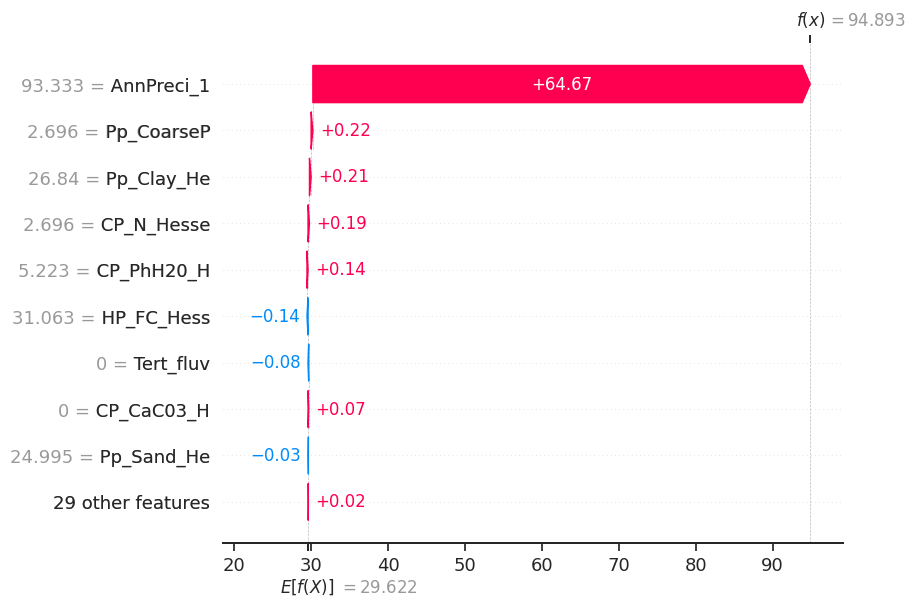

In [145]:
gbm_shap_train = df_multiannual_SFS.drop(columns=['Rn_Poten',
                                'grids_6k'],axis = 1)
gbm_explainer = shap.Explainer(model_gbm1)#

gbm_shap_values = gbm_explainer(gbm_shap_train)
gbm_waterfall = shap.plots.waterfall(gbm_shap_values[0])
gbm_waterfall

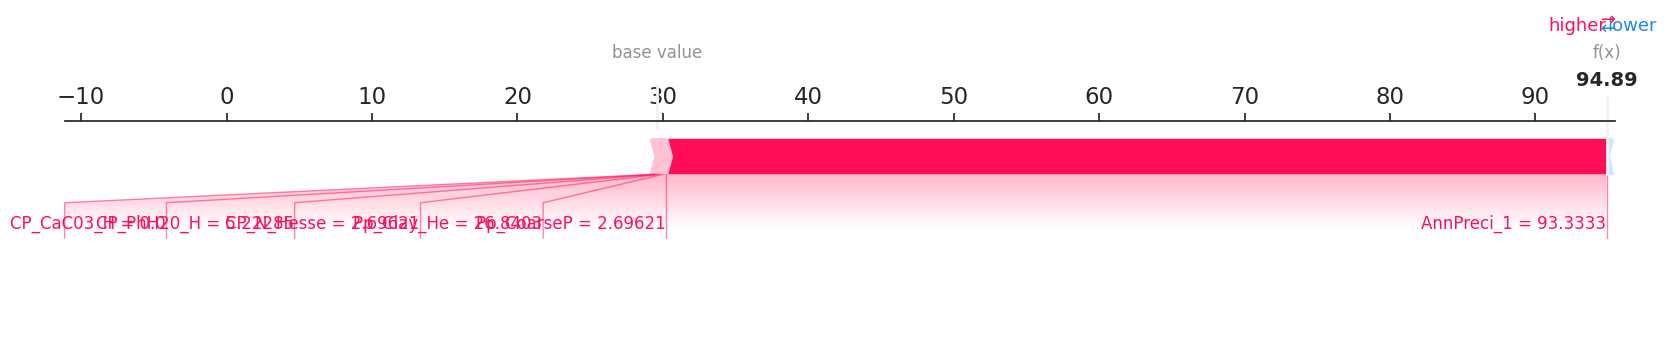

In [146]:
#visualize the first prediction's explanation
gbm_force_plot = shap.plots.force(gbm_shap_values[0], matplotlib=True)
gbm_force_plot


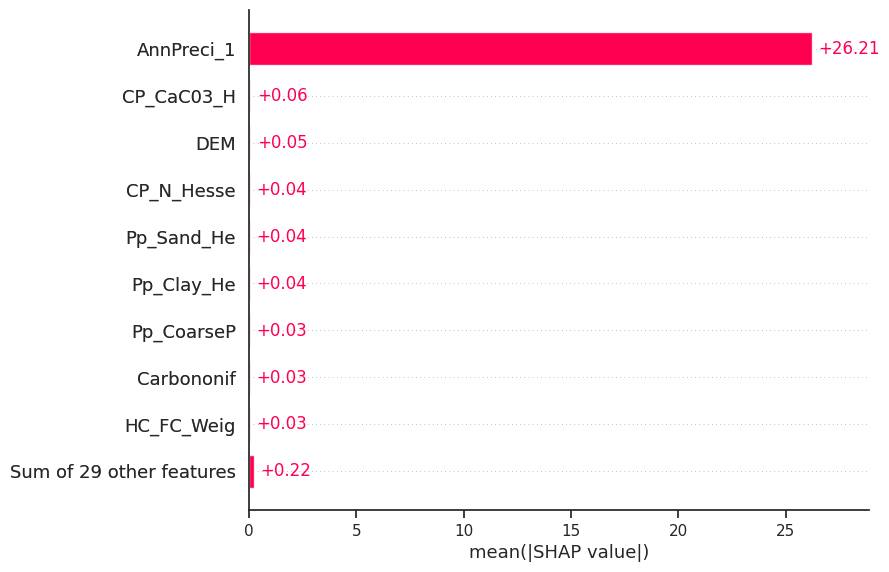

In [147]:
gbm_bar_plot_shap = shap.plots.bar(gbm_shap_values)
gbm_bar_plot_shap

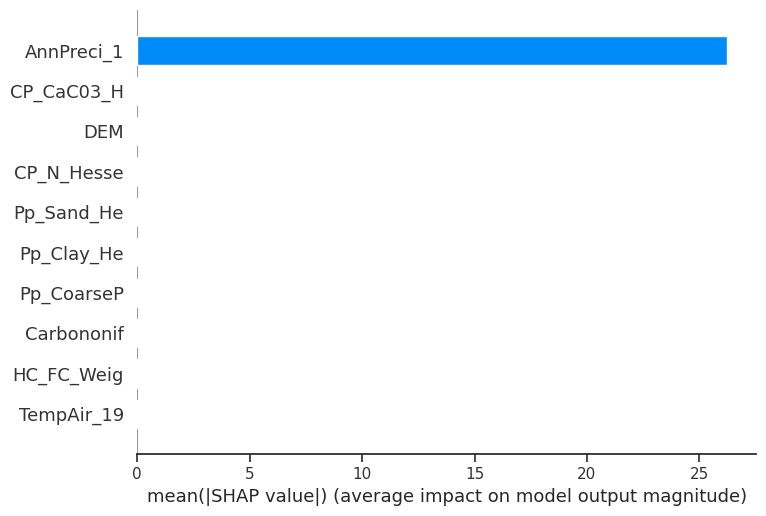

In [148]:
gbm_feat=list(gbm_shap_train)
shap.summary_plot(
    gbm_shap_values, features=gbm_shap_train,
    feature_names=gbm_feat, plot_type="bar",color_bar_label='Feature value',
    max_display=10)

### Top 10 and cordinates

### Saving models

In [149]:
import pickle

#def get_models(model_path):
# create an iterator object with write permission - model.pkl
with open(Model_path + '/final_mod_rf', 'wb') as files:
    pickle.dump(model_rf4, files)

# create an iterator object with write permission - model.pkl
with open(Model_path + '/final_mod_rf_coords', 'wb') as files:
    pickle.dump(model_rf5, files)

# create an iterator object with write permission - model.pkl
with open(Model_path + '/final_mod_svr', 'wb') as files:
    pickle.dump(model_svr4, files)

# create an iterator object with write permission - model.pkl
with open(Model_path + '/final_mod_svr_coords', 'wb') as files:
    pickle.dump(model_svr5, files)

# create an iterator object with write permission - model.pkl
with open(Model_path + '/final_mod_gbm', 'wb') as files:
    pickle.dump(model_gbm4, files)

  # create an iterator object with write permission - model.pkl
with open(Model_path + '/final_mod_gbm_coords', 'wb') as files:
     pickle.dump(model_gbm5, files)

## Neural Networks

In [150]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold

In [151]:
# 2. create network
params_2_MLP = { 'hidden_layer_sizes' : [10,10],
  'activation' : 'relu', 'solver' : 'adam',
  'alpha' : 0.0, 'batch_size' : 10,
  'random_state' : 0, 'tol' : 0.0001,
  'nesterovs_momentum' : False,
  'learning_rate' : 'constant',
  'learning_rate_init' : 0.01,
  'max_iter' : 1000, 'shuffle' : True,
  'n_iter_no_change' : 50, 'verbose' : False }

In [152]:
param_MLP = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,1)],
          'activation': ['relu','tanh','logistic'],
          'alpha': [0.0001, 0.05],
          'learning_rate': ['constant','adaptive'],
          'solver': ['adam']}
MLP_=MLPRegressor()
MLP_grid = GridSearchCV(MLP_,param_MLP,scoring='neg_mean_squared_error',
                        verbose=0, n_jobs=-1)

In [153]:
#importance_MLP_grid, metrics_MLP_grid, avg_metrics_score_MLP_grid, best_estimator_MLP_grid = GridSearchCV_params(df__xy, target_column, group_column, MLP_grid)


In [154]:
#best_estimator_MLP_grid

In [155]:
model_mlreg = MLPRegressor(max_iter= 1000, hidden_layer_sizes=(50,50,50), activation='tanh',
                  learning_rate='constant',alpha=0.0001,
                  solver='adam', random_state=9)

In [156]:
def SFS_Algorithm(data_, groups, base_estimator):
  X = data_.drop(columns=[target_column, group_column])
  y = data_[target_column]
  groups = data_[group_column]
  #feat_groups=feature_groups(data_)
  sfs = SFS(base_estimator,
            k_features=10,
            forward=True,
            floating=False,
            scoring='r2',
            verbose=2)
  sfs = sfs.fit(X, y)
  fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')
  Selected_Features = sfs.k_feature_names_
  sfs_metrics = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
  plt.title(f'SFS {base_estimator.__class__.__name__} :...(w. StdErr)')

  print('best combination (ACC: %.3f): %s\n' % (sfs.k_score_, sfs.k_feature_idx_))
  print('all subsets:\n', sfs.subsets_)

  plt.grid()
  plt.show()
  return fig, Selected_Features, sfs_metrics

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed: 16.7min

[2024-01-31 01:30:51] Features: 1/10 -- score: -0.13886792124053962[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed: 17.5min

[2024-01-31 01:52:20] Features: 2/10 -- score: -0.13445569798405047[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed: 19.3min

[2024-01-31 02:15:22] Features: 3/10 -- score: -0.13557865504696393[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed: 17.7min

[2024-01-31 02:36:13] Features: 4/10 -- score: -0.13251926585738336[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed: 18.4min

[2024-01-31 02:57:29] Features: 5/10 -- score: -0.13252949755950452[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed: 16.5min

[2024-01-31 03:16:17] Features: 6/10 -- score: -0.12644811504529221[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed: 17.8min

[2024-01-31 03:36:02] Features: 7/10 -- score: -0.13427313505874508[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed: 17.3min

[2024-01-31 03:54:58] Features: 8/1

best combination (ACC: -0.132): (9, 38, 40, 41, 42, 45, 47, 48, 49, 50)

all subsets:
 {1: {'feature_idx': (9,), 'cv_scores': array([-0.34656992, -0.00534169, -0.07117451, -0.01699814, -0.25425534]), 'avg_score': -0.13886792124053962, 'feature_names': ('HC_KS_Weig',)}, 2: {'feature_idx': (9, 38), 'cv_scores': array([-0.33811099, -0.00477019, -0.05922925, -0.015412  , -0.25475606]), 'avg_score': -0.13445569798405047, 'feature_names': ('HC_KS_Weig', 'Dev_mid')}, 3: {'feature_idx': (9, 38, 47), 'cv_scores': array([-0.32605368, -0.0084249 , -0.07226279, -0.01531464, -0.25583727]), 'avg_score': -0.13557865504696393, 'feature_names': ('HC_KS_Weig', 'Dev_mid', 'Tert_fluv')}, 4: {'feature_idx': (9, 38, 42, 47), 'cv_scores': array([-0.32509527, -0.00451054, -0.07007247, -0.01484812, -0.24806994]), 'avg_score': -0.13251926585738336, 'feature_names': ('HC_KS_Weig', 'Dev_mid', 'Palaeo_met', 'Tert_fluv')}, 5: {'feature_idx': (9, 38, 42, 45, 47), 'cv_scores': array([-0.32112369, -0.00418217, -0.0670

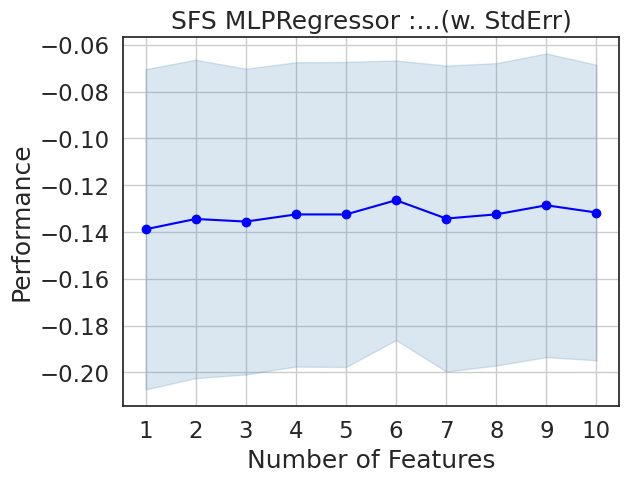

((<Figure size 640x480 with 1 Axes>,
  <Axes: title={'center': 'SFS MLPRegressor :...(w. StdErr)'}, xlabel='Number of Features', ylabel='Performance'>),
 ('HC_KS_Weig',
  'Dev_mid',
  'Dev_up',
  'Holocene',
  'Palaeo_met',
  'Perm_up_Ze',
  'Tert_fluv',
  'Tert_volc',
  'Trias_bund',
  'Trias_musc'),
                                 feature_idx  \
 1                                      (9,)   
 2                                   (9, 38)   
 3                               (9, 38, 47)   
 4                           (9, 38, 42, 47)   
 5                       (9, 38, 42, 45, 47)   
 6                   (9, 38, 40, 42, 45, 47)   
 7               (9, 38, 40, 41, 42, 45, 47)   
 8           (9, 38, 40, 41, 42, 45, 47, 48)   
 9       (9, 38, 40, 41, 42, 45, 47, 48, 50)   
 10  (9, 38, 40, 41, 42, 45, 47, 48, 49, 50)   
 
                                             cv_scores avg_score  \
 1   [-0.34656992191094727, -0.005341694777991179, ... -0.138868   
 2   [-0.3381109860701803, -0.0

In [157]:
SFS_Algorithm(df_train_SFS, groups, model_mlreg)

In [158]:
def mlp_model(X, Y):

  estimator=MLPRegressor()

  gsc = GridSearchCV(
      estimator,
      param_grid,
      cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)


  grid_result = gsc.fit(X, Y)
  best_params = grid_result.best_params_
  best_mlp = MLPRegressor(hidden_layer_sizes = best_params["hidden_layer_sizes"],
                          activation =best_params["activation"],
                          solver=best_params["solver"],
                          max_iter= 5000, n_iter_no_change = 200)
  scoring = {'abs_error': 'neg_mean_absolute_error',
            'squared_error': 'neg_mean_squared_error',
            'r2':'r2'}

  scores = cross_validate(best_mlp, X, Y, cv=10, scoring=scoring,
                          return_train_score=True, return_estimator = True)
  return scores

In [159]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold

# Assuming X, y, and groups are prepared
def get_MLPregressor_model(data, target_column, group_column):

  X = data.drop(columns=[target_column, group_column])
  y = data[target_column]
  groups = data[group_column].values

  # Initialize the neural network regressor
  model_mlpr = MLPRegressor(max_iter= 100000, hidden_layer_sizes=(50,50,50), activation='tanh',
                       learning_rate='constant',alpha=0.0001,
                       solver='adam', random_state=9)
  #model = MLPRegressor(hidden_layer_sizes=(50,50,50), activation='relu',
                       #solver='adam', random_state=42)
  # Perform group K Fold validation
  loo = LeaveOneGroupOut()
  mse_scores = []
  r2_scores = []
  for train_index, test_index in loo.split(X, y, groups=groups):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      model_mlpr.fit(X_train, y_train)
      predictions = model_mlpr.predict(X_train)
      mse = mean_squared_error(y_train, predictions)
      mse_scores.append(mse)
      r2 = r2_score(y_train, predictions)
      r2_scores.append(r2)

  # Calculate mean MSE
  mean_mse = sum(mse_scores) / len(mse_scores)
  mean_r2 = sum(r2_scores) / len(r2_scores)


  return mean_mse, mean_r2


### MLP All

In [160]:
def MLPR_with_loo_cv(data, target_column, group_column):
    X = data.drop(columns=[target_column, group_column])
    y = data[target_column]
    groups = data[group_column]

    model_mlpr = MLPRegressor(max_iter= 100000, hidden_layer_sizes=(50,50,50), activation='tanh',
                       learning_rate='constant',alpha=0.0001,
                       solver='adam', random_state=9)
    loo = LeaveOneGroupOut()

    metrics = {'RMSE': [],'R2 Score': [], 'MSE': [],
               'MAE': [], 'MAPE': [], 'RMSLE': [],
               'MBE': [], 'RRSE': [], 'R2 Adjusted': []}

    for train_index, test_index in loo.split(X, y, groups=groups):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        MLPR = model_mlpr.fit(X_train, y_train)
        y_pred = MLPR.predict(X_train)

        #MLPR_ = model_mlpr.fit(X_test, y_test)
        #y_predt = MLPR_.predict(X_test)

        #score_train_os = cross_val_score(model, ohne_seasonal1,
        #                                y,cv=loo, groups=groups_10pts)
        rmse = np.sqrt(mean_squared_error(y_train, y_pred))
        mse = mean_squared_error(y_train, y_pred)
        mae = mean_absolute_error(y_train, y_pred)
        r2 = r2_score(y_train, y_pred)
        mape = mean_absolute_percentage_error(y_train, y_pred)
        RMSLE = mean_squared_log_error(y_train, y_pred, squared=False)
        MBE =  np.mean(y_train - y_pred)
        RRSE = np.sqrt(relative_squared_error(y_train, y_pred))
        r2_adju = r2_adj(X,y_train,y_pred)


        metrics['RMSE'].append(rmse)
        metrics['R2 Score'].append(r2)
        metrics['MAE'].append(mae)
        metrics['MSE'].append(mse)
        metrics['MAPE'].append(mape)
        metrics['RMSLE'].append(RMSLE)
        metrics['MBE'].append(MBE)
        metrics['RRSE'].append(RRSE)
        metrics['R2 Adjusted'].append(r2_adju)

    MLR_pred_table = pd.DataFrame({ "actual": y_train,
                               "predicted_prob": y_pred } )
    MLR_pred_table['Residual'] = MLR_pred_table['actual'] - MLR_pred_table['predicted_prob']
    #MLR_pred_table0 = pd.DataFrame({ "actual": y_test,
    #                           "predicted_prob": y_predt } )
    #MLR_pred_table0['Residual'] = MLR_pred_table0['actual'] - MLR_pred_table0['predicted_prob']

    MLR_metrics_df = pd.DataFrame(metrics)

    MLR_avg_metrics_score = pd.DataFrame(np.mean(MLR_metrics_df,axis=0), columns =['Score'])

    return MLPR, MLR_avg_metrics_score, MLR_metrics_df, MLR_pred_table

In [161]:
model_MLP0 , avg_metrics_score_MLP0, metrics_df_MLP0 , pred_table_MLP0   = MLPR_with_loo_cv(df_train_SFS, target_column, group_column)

In [162]:
pred_table_main_test_MLP0 = get_val_scores(X_df_test_SFS, y_df_test_SFS, model_MLP0)

pred_table_main_test_MLP0

RMSE : 36.57439709428465
MSE : 1337.6865228104175
MAE: 18.357395313895097
r2: 0.0043939855445011
MAPE: 1.0325270988764579
RMSLE: 0.7690448750530426
MBE : 0.6559269943592593
RRSE : 0.9978005885223253
r2_adju: -0.20923807423744822


,actual,predicted_prob,Residual
0,10.083600,29.950738,-19.867138
1,43.464761,29.950738,13.514023
2,23.148511,29.950738,-6.802227
3,12.215218,29.950738,-17.735520
4,39.983907,29.950738,10.033169
...,...,...,...
296,9.724180,29.911702,-20.187522
297,9.525250,29.950738,-20.425488
298,31.950300,24.961521,6.988779
299,10.246700,10.577733,-0.331033


In [163]:
train_Scaled_multiannual.describe()

,Rn_Poten,AnnPreci_1,CP_CaC03_H,CP_CEC_Hes,CP_CN_Hess,CP_N_Hesse,CP_P_Hesse,CP_PhH20_H,DEM,HC_FC_Weig,...,Palaeo_met,Paleo_igne,Perm_low_m,Perm_up_Ze,Pleistocen,Tert_fluv,Tert_volc,Trias_bund,Trias_musc,Trias_keup
count,1208.000000,1208.000000,1208.000000,1208.000000,1208.000000,1208.000000,1208.000000,1208.000000,1208.000000,1208.000000,...,1208.000000,1208.000000,1208.000000,1208.000000,1208.000000,1208.000000,1208.000000,1208.000000,1208.000000,1208.000000
mean,0.083613,0.550030,0.262833,0.505882,0.519797,0.364413,0.646871,0.821126,0.183251,0.556061,...,0.097682,0.014073,0.009934,0.011589,0.068709,0.022351,0.043874,0.138245,0.005795,0.002483
std,0.073761,0.113571,0.175998,0.209353,0.111120,0.152759,0.203208,0.128422,0.221184,0.178390,...,0.297007,0.117840,0.099213,0.107073,0.253063,0.147884,0.204900,0.345300,0.075934,0.049793
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.037828,0.463875,0.101554,0.336134,0.441066,0.264199,0.498986,0.734607,0.006700,0.415544,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.063625,0.483579,0.280383,0.468435,0.490612,0.316735,0.733373,0.876209,0.010050,0.548836,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.109471,0.623153,0.381507,0.658018,0.586295,0.451303,0.776730,0.910033,0.335008,0.682128,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Multiannual

In [164]:
#pred_table_MLP2, model_MLP2 , avg_metrics_score_MLP2, metrics_df_MLP2 , pred_table_MLP2   = MLPR_with_loo_cv(train_Scaled_multiannual, target_column, group_column)

In [165]:
#avg_metrics_score_MLP2

### Validation

In [166]:
#pred_table_scaled_MLP2_test = get_val_scores(X_test_Scaled_multiannual, y_test_Scaled_multiannual, model_MLP2)
#pred_table_rf3_test

# FINAL MLP

In [167]:
model_MLPf , avg_metrics_score_MLPf, metrics_df_MLPf , pred_table_MLPf   = MLPR_with_loo_cv(rf_final_predictors, target_column, group_column)

In [168]:
pred_table_MLPf

,actual,predicted_prob,Residual
1,34.96750,40.349517,-5.382017
11,54.86940,38.388748,16.480652
13,5.69968,39.425170,-33.725490
14,7.87867,39.252305,-31.373635
17,12.10180,40.407465,-28.305665
...,...,...,...
1203,24.33120,14.330391,10.000809
1204,29.26080,16.084320,13.176480
1205,4.51200,16.311450,-11.799450
1206,11.78000,16.311450,-4.531450


In [169]:
avg_metrics_score_MLPf

,Score
RMSE,21.782020
R2 Score,0.175805
MSE,489.642767
MAE,13.122799
MAPE,0.836245
RMSLE,0.646342
MBE,0.783215
RRSE,0.904064
R2 Adjusted,0.158372


## Validation


In [170]:
pred_table_test_MLP3 = get_val_scores(X_test_multiannual, y_test_multiannual, model_MLPf)
#pred_table_rf3_test
pred_table_test_MLP3

RMSE : 29.29694526343537
MSE : 858.311001768728
MAE: 9.566166345216482
r2: 0.3611809784560571
MAPE: 0.40447029053376266
RMSLE: 0.4124400710595284
MBE : 0.8340514758798006
RRSE : 0.799261547645039
r2_adju: 0.2657252625931691


,actual,predicted_prob,Residual
0,10.083600,17.242897,-7.159297
1,43.464761,58.993067,-15.528307
2,23.148511,17.362980,5.785531
3,12.215218,17.242945,-5.027726
4,39.983907,58.477174,-18.493267
...,...,...,...
296,9.724180,14.626574,-4.902394
297,9.525250,17.243091,-7.717841
298,31.950300,33.585918,-1.635618
299,10.246700,14.622650,-4.375950


### shap

In [171]:
#shap.plots.bar(svr_shap_values)
# explain all the predictions in the test set
#MLP_explainer = shap.KernelExplainer(model_MLP2.predict, shap_train)
#MLP_shap_values = MLP_explainer.shap_values(Top_10rf_wo_coords_test, nsamples=50)


In [172]:
#feat_namees = list(Top_10rf_wo_coords_test)
#shap.plots._waterfall.waterfall_legacy(MLP_explainer.expected_value,
#                                       MLP_shap_values[0], feature_names=feat_namees)


In [173]:
#shap.summary_plot(
#    MLP_shap_values, features=Top_10rf_wo_coords_test,
#    feature_names=feat_namees, plot_type="bar",color_bar_label='Feature value',
#    max_display=10)

In [174]:
Model_path

'/content/drive/MyDrive/feature selection/Modelling/Models'

In [175]:
# create an iterator object with write permission - model.pkl
with open(Model_path + '/final_mod_MLP', 'wb') as files:
     pickle.dump(model_MLPf, files)
# create an iterator object with write permission - model.pkl
with open(Model_path + '/final_mod_RF', 'wb') as files:
     pickle.dump(model_rff, files)
# create an iterator object with write permission - model.pkl
with open(Model_path + '/final_mod_SVR', 'wb') as files:
     pickle.dump(model_svrf, files)
# create an iterator object with write permission - model.pkl
with open(Model_path + '/final_mod_GBM', 'wb') as files:
     pickle.dump(model_gbmf, files)

In [176]:
raster_path

'/content/drive/MyDrive/feature selection/Modelling/Data/Raster data'

# Make prediction on raster

In [177]:
rf_data = raster_path + '/Input raster/rf_predictors.tif'

svr_data = raster_path + '/Input raster/svr_predictors.tif'

gbm_data = raster_path + '/Input raster/gbm_predictors.tif'

MLP_data = raster_path + '/Input raster/rf_predictors.tif'

#raster_stack_path_coords_2 = raster_paths + 'test_data/rf_coords_predictor_bands_nodata.tif'
#_---------------------------------------------------------------------------------------------------#
#top_10_no_coords = raster_paths + 'test_data/Top_10_woo_coords.tif'

#output_predicted_raster_path_coords_1 = raster_paths +  'test_data/predicted_raster_coords_1.tif'
#output_predicted_raster_path_coords_2 = raster_paths +  'test_data/predicted_raster_coords_nd.tif'

## Reading stack with gdal

In [178]:
!pip install gdal

In [179]:
rf_data

'/content/drive/MyDrive/feature selection/Modelling/Data/Raster data/Input raster/rf_predictors.tif'

In [180]:
rf_final_predictors.shape

(1208, 27)

In [181]:
rf_model_df=gdal.Open(rf_data, gdal.GA_ReadOnly)
print ('Driver:', rf_model_df.GetDriver().ShortName)
bands_rf = rf_model_df.RasterCount
print('Bands in image:', rf_model_df.RasterCount)

Driver: GTiff
Bands in image: 25


In [182]:
rf_predictor_feature_names = rf_final_predictors.drop(columns=['Rn_Poten','grids_6k'], axis=1)
svr_predictor_feature_names = svr_final_predictors.drop(columns=['Rn_Poten','grids_6k'], axis=1)
gbm_predictor_feature_names = gbm_final_predictors.drop(columns=['Rn_Poten','grids_6k'], axis=1)
MLP_predictor_feature_names = rf_final_predictors.drop(columns=['Rn_Poten','grids_6k'], axis=1)


In [183]:
#ax.set_title('{band_names}'.format(i))
#list(top_10rf_feature_names)

In [184]:
def gdal_raster_stack_plot(raster_band_file, raster_band_count,band_names ):
  band_names = list(band_names)
  names = tuple(band_names)
  plt.figure(figsize=(15,7))
  for i in range(1, raster_band_count+1):
    raster_band_count=raster_band_file.GetRasterBand(i)
    #raster_band_count.SetDescription(names)
    data=raster_band_count.ReadAsArray()
    ax=plt.subplot(2,5,i)
    plt.axis("off")
    plt.imshow(data)
    #for i in band_names:
    ax.set_title(band_names[i-1],fontsize=12 )
  plt.show()
  plt.tight_layout()

#gdal_raster_stack_plot(rf_model_df,bands_rf,top_10rf_feature_names )

In [185]:
rf_data

'/content/drive/MyDrive/feature selection/Modelling/Data/Raster data/Input raster/rf_predictors.tif'

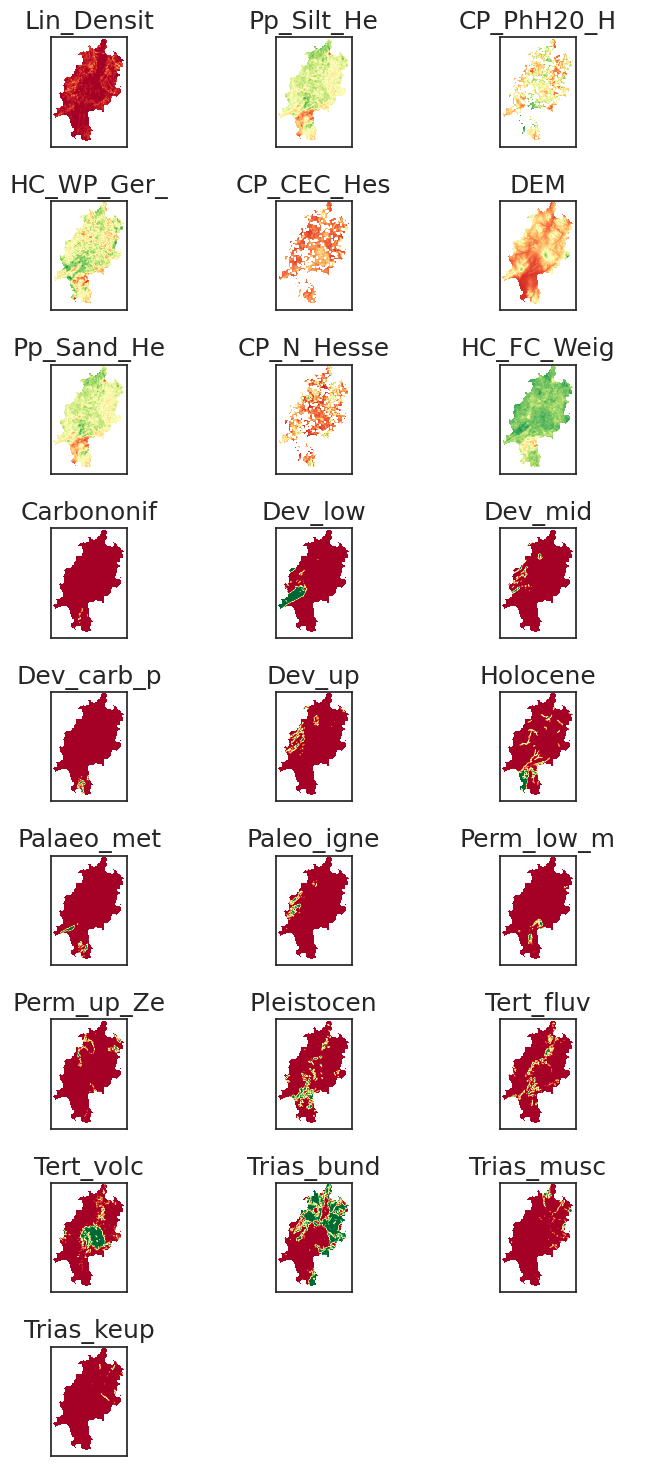

In [186]:
with rio.open(rf_data) as rf_model_data_:
  rf_model_data_ = rf_model_data_.read(masked=True)

band_titlez = list(rf_predictor_feature_names)
ep.plot_bands(rf_model_data_, cbar=False,figsize=(7,15),
              cmap='RdYlGn', cols=3,
              scale=False,
              title=band_titlez)

plt.show()

### rf_final_model_tten

In [187]:
#from pdpbox import pdp, get_dataset, info_plots
#from plotnine import *


# Create partial dependence plot for a specific feature
#feature_name = 'RM'  # Replace with the feature you want to plot
#pdp_dist = pdp.pdp_isolate(model=model, dataset=X, model_features=X.columns, feature=feature_name)

# Plot the partial dependence plot using plotnine
#pdp_plot = pdp.pdp_plot(pdp_dist, feature_name)
#g = ggplot() + theme_minimal() + theme(axis_text_x=element_text(rotation=45, hjust=1))
#g += pdp_plot
#print(g)


In [188]:
import rasterio

In [189]:
Xrf = rf_final_predictors.drop(columns=[target_column, group_column])
yrf = rf_final_predictors[target_column]
groups_rf = rf_final_predictors[group_column]

loo = LeaveOneGroupOut()
estimating_model = RandomForestRegressor(n_estimators=1000,max_depth=10, random_state=24)

for train_index, test_index in loo.split(Xrf, yrf, groups=groups_rf):
    X_train, X_test = Xrf.iloc[train_index], Xrf.iloc[test_index]
    y_train, y_test = yrf.iloc[train_index], yrf.iloc[test_index]

    output_model_rf = estimating_model.fit(X_train, y_train)
    y_pred = output_model_rf.predict(X_train)

In [190]:
def predict_raster(input_stack, model, output_path):
    # Open the raster stack
      with rasterio.open(input_stack) as src:
        # Read the raster stack data
        raster_stack = src.read()

        # Reshape the raster stack to fit the sklearn RandomForestRegressor input shape
        bands, rows, cols = raster_stack.shape
        reshaped_stack = np.moveaxis(raster_stack, 0, -1)
        reshaped_stack = reshaped_stack.reshape(-1, bands)

        #filled_raster_stack = reshaped_stack.copy()
        #num_bands = filled_raster_stack.shape[0]

        #for i in range(bands):
         # band = reshaped_stack[i]
          #band[np.isnan(band)] = np.nanmean(band)


        # Predict using the Random Forest model
        predictions = model.predict(reshaped_stack)

        # Reshape the predictions back to raster shape
        predicted_raster = predictions.reshape(rows, cols)

        # Get metadata from the source raster
        meta = src.meta

        # Update metadata for the output raster
        meta.update({
            'count': 1,  # Number of bands in the output raster
            'dtype': 'float32'  # Data type of the output raster
        })

        # Write the predicted raster to a new file
        with rasterio.open(output_path, 'w', **meta) as dst:
            dst.write(predicted_raster, 1)  # Write the predicted raster to the output file

# Path to save the predicted raster
predicted_rff = raster_path +  '/predicted raster/rf_predicted_final.tif'

In [191]:
rf_map_predicted = predict_raster(rf_data, output_model_rf,predicted_rff)

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


### rf predicted plot

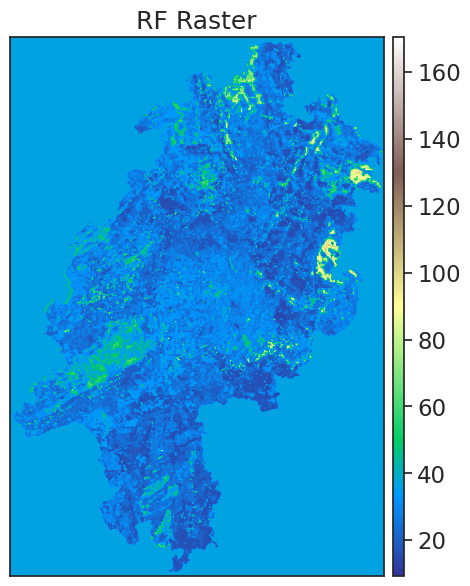

In [192]:
#rf_final_model_tten = raster_paths +  'test_data/rf_final_model_tten_pred_raster.tif'

with rio.open(predicted_rff) as rf_map:
  rf_map = rf_map.read(masked=True)

fig, ax = plt.subplots(figsize = (10, 7))
ep.plot_bands(rf_map,
              title="RF Raster",
              cmap="terrain", ax=ax)
plt.show()

#### SCORES

In [193]:
def random_forest_metrics(rf_final_predictors, target_column, group_column):
    X_rff = rf_final_predictors.drop(columns=[target_column, group_column])
    y_rff = rf_final_predictors[target_column]
    groups = rf_final_predictors[group_column]

    metrics = {'RMSE': [],'R2 Score': [], 'MSE': [],
               'MAE': [], 'MAPE': [], 'RMSLE': [],
               'MBE': [], 'RRSE': [], 'R2 Adjusted': []}


    #output_model_rf = output_model.fit(X_train, y_train)
    y_pred_rff = output_model_rf.predict(X_rff)

    rmse = np.sqrt(mean_squared_error(y_rff, y_pred_rff))
    mse = mean_squared_error(y_rff, y_pred_rff)
    mae = mean_absolute_error(y_rff, y_pred_rff)
    r2 = r2_score(y_rff, y_pred_rff)
    mape = mean_absolute_percentage_error(y_rff, y_pred_rff)
    RMSLE = mean_squared_log_error(y_rff, y_pred_rff, squared=False)
    MBE =  np.mean(y_rff - y_pred_rff)
    RRSE = np.sqrt(relative_squared_error(y_rff, y_pred_rff))
    r2_adju = r2_adj(X_rff,y_rff,y_pred_rff)


    metrics['RMSE'].append(rmse)
    metrics['R2 Score'].append(r2)
    metrics['MAE'].append(mae)
    metrics['MSE'].append(mse)
    metrics['MAPE'].append(mape)
    metrics['RMSLE'].append(RMSLE)
    metrics['MBE'].append(MBE)
    metrics['RRSE'].append(RRSE)
    metrics['R2 Adjusted'].append(r2_adju)

    pred_table_rff = pd.DataFrame({ "actual": y_rff,
                                "predicted_prob": y_pred_rff } )
    pred_table_rff['Residual'] = pred_table_rff['actual'] - pred_table_rff['predicted_prob']

    metrics_rff = pd.DataFrame(metrics)

    avg_metrics_score_rff = pd.DataFrame(np.mean(metrics_rff,axis=0), columns =['Score'])

    #avg_feature_importance =  pd.DataFrame(avg_feature_df, columns =['Score'])

    result_imp_rff = permutation_importance(output_model_rf, X_rff, y_rff,
                                    n_repeats=15,random_state=0)

    return output_model_rf, avg_metrics_score_rff, metrics_rff, pred_table_rff, result_imp_rff #pred_table_0


#def predict_on_separate_data(output_model, data):
#    X = output_model.drop(columns=[target_column])
#    return output_model.predict(X)

def get_RFF_feature_importance(output_model, feature_names, result_imp):

    hlnug_imp = result_imp.importances_mean
    importance = output_model_rf.feature_importances_
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    rf_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': hlnug_imp})
    Rf_importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
    Rf_imp_df = rf_imp_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
    return Rf_importance_df, Rf_imp_df


# Assuming you have your data in a DataFrame named 'your_data'
target_column = 'Rn_Poten'
group_column = 'grids_6k'



### Model results
def get_RFF_results(input_dat,target_column, group_column):
  # Train the model using the function with LOO CV
  RF_regr_rff, rf_avg_score, rf_metrics_df, rf_pred_table, perm_imp_rf = random_forest_metrics(input_dat,
                                                               target_column, group_column)


  # Get feature importance
  feature_names = input_dat.drop(columns=[target_column, group_column]).columns.tolist()
  rf_feature_importance_df,Rf_imp_df = get_RFF_feature_importance(RF_regr_rff, feature_names, perm_imp_rf)

  return rf_avg_score, rf_metrics_df, rf_pred_table, RF_regr_rff, rf_feature_importance_df, Rf_imp_df

In [194]:
avg_score_rfx, metrics__rfx, pred_table_rfx, model_rfx, fimp_rfx, permut_imp_rfx = get_RFF_results(rf_final_predictors,target_column, group_column)

In [195]:
avg_score_rfx

,Score
RMSE,14.863408
R2 Score,0.603373
MSE,220.920884
MAE,9.403978
MAPE,0.612213
RMSLE,0.516478
MBE,0.092604
RRSE,0.629783
R2 Adjusted,0.594984


In [196]:
pred_table_rfx

,actual,predicted_prob,Residual
0,39.6215,29.799195,9.822305
1,34.9675,33.608811,1.358689
2,30.8939,34.032821,-3.138921
3,19.7975,28.157898,-8.360398
4,21.7379,23.472819,-1.734919
...,...,...,...
1203,24.3312,18.916389,5.414811
1204,29.2608,17.101786,12.159014
1205,4.5120,8.640534,-4.128534
1206,11.7800,8.640534,3.139466


In [197]:
fimp_rfx

,Feature,Importance
0,HC_WP_Ger_,0.177886
1,CP_PhH20_H,0.122634
2,HC_FC_Weig,0.122420
3,Lin_Densit,0.090279
4,CP_N_Hesse,0.090224
5,DEM,0.090068
6,CP_CEC_Hes,0.065527
7,Pp_Silt_He,0.059202
8,Pp_Sand_He,0.055428
9,Tert_volc,0.044374


In [198]:
fimp_rfx_index = fimp_rfx.set_index(['Feature'])
sum_geo_values_rfx = fimp_rfx_index.loc[feature_groups_list].sum()
print(sum_geo_values_rfx)

Xrf_predictors_test = rf_final_predictors_test.drop(columns=[target_column,group_column], axis=1)
yrf_predictors_test = rf_final_predictors_test.Rn_Poten
pred_table_test_rffx = get_val_scores(Xrf_predictors_test, yrf_predictors_test, output_model_rf)
#pred_table_rf3_test
pred_table_test_rffx

#gbm_final_predictors_test = df_test_multiannual_SFS[gbm_final_predictors_list]

Importance    0.126332
dtype: float64
RMSE : 20.786513757296053
MSE : 432.07915418225804
MAE: 9.200489510140525
r2: 0.6784144885298602
MAPE: 0.5223398660631037
RMSLE: 0.46467626079163105
MBE : -0.45224687760856125
RRSE : 0.5670851007301636
r2_adju: 0.6491794420325747


,actual,predicted_prob,Residual
0,10.083600,25.565577,-15.481977
1,43.464761,29.563000,13.901761
2,23.148511,25.969483,-2.820973
3,12.215218,25.969483,-13.754265
4,39.983907,29.563000,10.420907
...,...,...,...
296,9.724180,18.191983,-8.467803
297,9.525250,16.030847,-6.505597
298,31.950300,42.494080,-10.543780
299,10.246700,22.435669,-12.188969


In [199]:
rf_final_predictors_test.shape

(301, 27)

In [200]:
seived = rf_final_predictors[rf_final_predictors['Rn_Poten'] ==		9.46138
]
seived

,Lin_Densit,Pp_Silt_He,CP_PhH20_H,HC_WP_Ger_,CP_CEC_Hes,DEM,Pp_Sand_He,CP_N_Hesse,HC_FC_Weig,Carbononif,...,Perm_low_m,Perm_up_Ze,Pleistocen,Tert_fluv,Tert_volc,Trias_bund,Trias_musc,Trias_keup,Rn_Poten,grids_6k


In [201]:
xc=pred_table_rfx[pred_table_rfx['actual'] ==	29.7072]
#xc

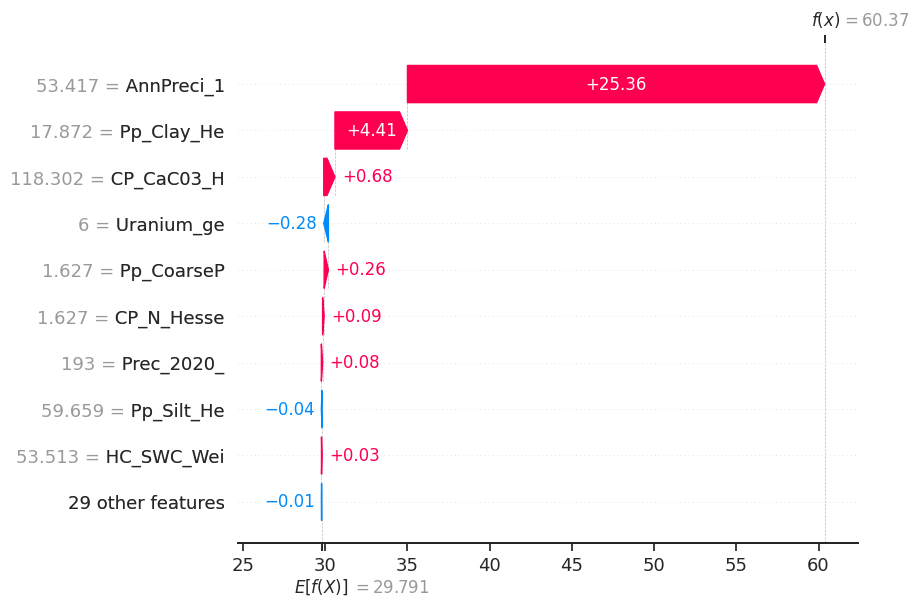

In [202]:
shap.plots.waterfall(rf_shap_values[695])

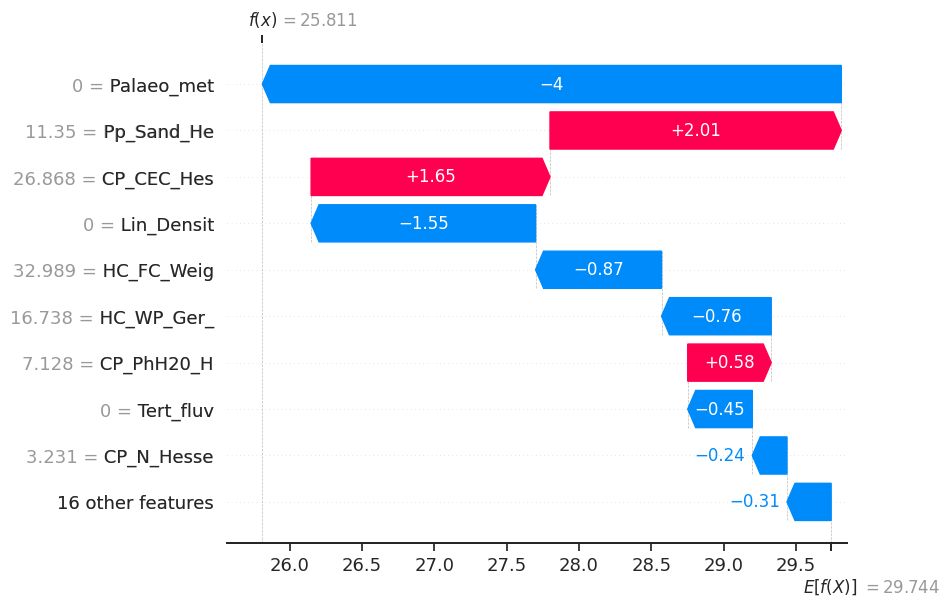

In [203]:
RF_explainer = shap.Explainer(output_model_rf)
shap_train = rf_final_predictors.drop(columns=['Rn_Poten',
                                'grids_6k'],axis = 1)
rf_shap_values = RF_explainer(shap_train)

# visualize the first prediction's explanation
shap.plots.waterfall(rf_shap_values[926])

In [204]:
Xrf = rf_final_predictors.drop(columns=[target_column, group_column])
yrf = rf_final_predictors[target_column]
groups_rf = rf_final_predictors[group_column]

columns = list(rf_final_predictors)
loo = LeaveOneGroupOut()
estimating_model = RandomForestRegressor(n_estimators=1000,max_depth=10, random_state=24)

list_shap_values = list()
list_test_sets = list()

for train_index, test_index in loo.split(Xrf, yrf, groups=groups_rf):
    X_train, X_test = Xrf.iloc[train_index], Xrf.iloc[test_index]
    y_train, y_test = yrf.iloc[train_index], yrf.iloc[test_index]

    X_train = pd.DataFrame(X_train,columns=columns)
    X_test = pd.DataFrame(X_test,columns=columns)

# https://stackoverflow.com/questions/72720106/shap-values-with-cross-validation-do-i-implement-the-shap-values-on-axis-0-or#


    #explaining model
    explainer = shap.TreeExplainer(output_model_rf)
    shap_values = explainer.shap_values(X_test)
    #for each iteration we save the test_set index and the shap_values
    list_shap_values.append(shap_values)


  # flatten list of lists, pick the sv for 1 class, stack the result
    shap_values = np.vstack([sv[1] for sv in list_shap_values])
    sv = np.abs(shap_values).mean(0)  # <-- error corrected
    importance_df = pd.DataFrame({
        "column_name": columns,
        "shap_values": sv
    })


In [205]:
rf_shap_values = explainer(shap_train)
shap.plots.waterfall(shap_values[0])

TypeError: The waterfall plot requires an `Explanation` object as the `shap_values` argument.

In [ ]:
importance_df

In [ ]:
    rf_shap_values = RF_explainer(shap_train)


In [ ]:
X_train = pd.DataFrame(X_train,columns=columns)
X_test = pd.DataFrame(X_test,columns=columns)

# https://stackoverflow.com/questions/72720106/shap-values-with-cross-validation-do-i-implement-the-shap-values-on-axis-0-or#

    #training model
    clf = RandomForestClassifier(random_state=0)
    clf.fit(X_train, y_train)

    #explaining model
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X_test)
    #for each iteration we save the test_set index and the shap_values
    list_shap_values.append(shap_values)


# flatten list of lists, pick the sv for 1 class, stack the result
shap_values = np.vstack([sv[1] for sv in list_shap_values])
sv = np.abs(shap_values).mean(0)  # <-- error corrected
importance_df = pd.DataFrame({
    "column_name": columns,
    "shap_values": sv
})

In [ ]:
seived = rf_final_predictors_test[rf_final_predictors_test['Rn_Poten'] ==	13.6085]
seived

### SVR_Prediction

In [ ]:
train_multiannual.columns

In [ ]:
Xsvr = svr_final_predictors.drop(columns=[target_column, group_column])
ysvr = svr_final_predictors[target_column]
groups_svr = svr_final_predictors[group_column]

loo = LeaveOneGroupOut()
estimating_model_svr = SVR(kernel='rbf', C=10.0, epsilon=0.1, gamma = 0.05)


for train_index, test_index in loo.split(Xsvr, ysvr, groups=groups_svr):
    X_train, X_test = Xsvr.iloc[train_index], Xsvr.iloc[test_index]
    y_train, y_test = ysvr.iloc[train_index], ysvr.iloc[test_index]

    output_model_svr = estimating_model_svr.fit(X_train, y_train)
    y_pred = output_model_svr.predict(X_train)

In [ ]:
predicted_svr = raster_path +  '/predicted raster/svm_predicted_final.tif'

svr_predicted = predict_raster(svr_data, estimating_model_svr,
                                         predicted_svr)

In [ ]:
#rf_final_model_tten = raster_paths +  'test_data/rf_final_model_tten_pred_raster.tif'

with rio.open(predicted_svr) as svr_predicted:
  svr_predicted = svr_predicted.read(masked=True)

fig, ax = plt.subplots(figsize = (10, 7))
ep.plot_bands(svr_predicted,
              title="top_10svr_predicted Raster",
              cmap="terrain", ax=ax)
plt.show()

### Get metrics

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.feature_selection import f_regression

def svr_results(svr_final_predictors, target_column, group_column, output_model_svr):
    Xsvr = svr_final_predictors.drop(columns=[target_column, group_column])
    ysvr = svr_final_predictors[target_column]
    groups_svr = svr_final_predictors[group_column].values

    metrics = {'RMSE': [],'R2 Score': [], 'MSE': [],
                  'MAE': [], 'MAPE': [], 'RMSLE': [],
                  'MBE': [], 'RRSE': [], 'R2 Adjusted': []}

    feature_importance = []

    y_predsvr = output_model_svr.predict(Xsvr)

    importance = f_regression(Xsvr, ysvr)[0]  # Extract feature importance using f_regression
    feature_importance.append(importance)

    rmse = np.sqrt(mean_squared_error(ysvr, y_predsvr))
    mse = mean_squared_error(ysvr, y_predsvr)
    mae = mean_absolute_error(ysvr, y_predsvr)
    r2 = r2_score(ysvr, y_predsvr)
    mape = mean_absolute_percentage_error(ysvr, y_predsvr)
    RMSLE = mean_squared_log_error(ysvr, y_predsvr, squared=False)
    MBE =  np.mean(ysvr - y_predsvr)
    RRSE = np.sqrt(relative_squared_error(ysvr, y_predsvr))
    r2_adju = r2_adj(Xsvr,ysvr,y_predsvr)

    metrics['RMSE'].append(rmse)
    metrics['R2 Score'].append(r2)
    metrics['MAE'].append(mae)
    metrics['MSE'].append(mse)
    metrics['MAPE'].append(mape)
    metrics['RMSLE'].append(RMSLE)
    metrics['MBE'].append(MBE)
    metrics['RRSE'].append(RRSE)
    metrics['R2 Adjusted'].append(r2_adju)

    pred_table = pd.DataFrame({ "actual": ysvr,
                               "predicted_prob": y_predsvr } )
    pred_table['Residual'] = pred_table['actual'] - pred_table['predicted_prob']
    #pred_table_0 = pd.DataFrame({ "actual": y_test,
    #                           "predicted_prob": y_predt } )
    #pred_table_0['Residual'] = pred_table_0['actual'] - pred_table_0['predicted_prob']

    metrics_df = pd.DataFrame(metrics)

    avg_metrics_score = pd.DataFrame(np.mean(metrics_df,axis=0), columns =['Score'])

    # Calculate mean feature importance across all folds
    mean_importance = np.mean(feature_importance, axis=0)

    # Create a DataFrame to store feature importance
    importance_df = pd.DataFrame({'Feature': Xsvr.columns, 'Importance': mean_importance})
    importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

    return output_model_svr, pred_table, importance_df, metrics_df, avg_metrics_score

In [ ]:
model_svrx, pred_table_svrx, fimp_svrx, metrics_svrx, avg_score_svrx = svr_results(svr_final_predictors,target_column, group_column, output_model_svr)

In [ ]:
avg_score_svrx

In [ ]:
fimp_svrx

In [ ]:
pred_table_svrx

In [ ]:
fimp_svrx_index = fimp_svrx.set_index(['Feature'])
sum_geo_values_svrx = fimp_svrx_index.loc[feature_groups_list].sum()
print(sum_geo_values_svrx)

Xsvr_predictors_test = svr_final_predictors_test.drop(columns=[target_column,group_column], axis=1)
ysvr_predictors_test = svr_final_predictors_test.Rn_Poten
pred_table_test_svrfx = get_val_scores(Xsvr_predictors_test, ysvr_predictors_test, output_model_svr)
#pred_table_rf3_test
pred_table_test_svrfx

#gbm_final_predictors_test = df_test_multiannual_SFS[gbm_final_predictors_list]

### GBM Predictions

#### GBM main prediction

In [ ]:
Xgbm = gbm_final_predictors.drop(columns=[target_column, group_column])
ygbm = gbm_final_predictors[target_column]
groups_gbm = gbm_final_predictors[group_column]

loo = LeaveOneGroupOut()
estimating_model_gbm = GradientBoostingRegressor(n_estimators=100, max_depth=None, learning_rate=0.1)

for train_index, test_index in loo.split(Xgbm, ygbm, groups=groups_gbm):
    X_train, X_test = Xgbm.iloc[train_index], Xgbm.iloc[test_index]
    y_train, y_test = ygbm.iloc[train_index], ygbm.iloc[test_index]

    output_model_gbm = estimating_model_gbm.fit(X_train, y_train)
    y_pred = output_model_gbm.predict(X_train)

In [ ]:
# Path to save the predicted raster
predicted_gbm = raster_path +  '/predicted raster/gbm_predicted_final.tif'

# Make predictions using the function
gbm_prediction = predict_raster(gbm_data, output_model_gbm,
                                      predicted_gbm)

In [ ]:
#rf_final_model_tten = raster_paths +  'test_data/rf_final_model_tten_pred_raster.tif'

with rio.open(predicted_gbm) as gbm_predicted:
  gbm_predicted = gbm_predicted.read(masked=True)

fig, ax = plt.subplots(figsize = (10, 7))
ep.plot_bands(gbm_predicted,
              title="gbm_predicted Raster",
              cmap="terrain", ax=ax)
plt.show()

### Metrics

In [ ]:
def gbm_metrics(gbm_final_predictors, target_column, group_column, output_model_gbm):
    Xgbm = gbm_final_predictors.drop(columns=[target_column, group_column])
    ygbm = gbm_final_predictors[target_column]
    groups_gbm = gbm_final_predictors[group_column]

    loo = LeaveOneGroupOut()

    metrics = {'RMSE': [],'R2 Score': [], 'MSE': [],
                  'MAE': [], 'MAPE': [],'RMSLE':[],
                  'MBE': [], 'RRSE': [], 'R2 Adjusted': []}

    gbm_feature_importance = []
    y_predgbm = output_model_gbm.predict(Xgbm)

    #gbmr__ = gbm.fit(X_test, y_test)
    #y_predt = gbmr__.predict(X_test)

    gbm_importance = f_regression(Xgbm, ygbm)[0]  # Extract feature importance using f_regression
    gbm_feature_importance.append(gbm_importance)

    rmse = np.sqrt(mean_squared_error(ygbm, y_predgbm))
    mse = mean_squared_error(ygbm, y_predgbm)
    mae = mean_absolute_error(ygbm, y_predgbm)
    r2 = r2_score(ygbm, y_predgbm)
    mape = mean_absolute_percentage_error(ygbm, y_predgbm)
    RMSLE = mean_squared_log_error(ygbm, y_predgbm, squared=False)
    MBE =  np.mean(ygbm - y_predgbm)
    RRSE = np.sqrt(relative_squared_error(ygbm, y_predgbm))

    r2_adju = r2_adj(Xgbm,ygbm,y_predgbm)

    metrics['RMSE'].append(rmse)
    metrics['R2 Score'].append(r2)
    metrics['MAE'].append(mae)
    metrics['MSE'].append(mse)
    metrics['MAPE'].append(mape)
    metrics['RMSLE'].append(RMSLE)
    metrics['MBE'].append(MBE)
    metrics['RRSE'].append(RRSE)
    metrics['R2 Adjusted'].append(r2_adju)


    gbm_pred_table = pd.DataFrame({ "actual": ygbm,
                                  "predicted_prob": y_predgbm } )
    gbm_pred_table['Residual'] = gbm_pred_table['actual'] - gbm_pred_table['predicted_prob']
    #gbm_pred_table0 = pd.DataFrame({ "actual": y_test,
    #                                  "predicted_prob": y_predt } )
    #gbm_pred_table0['Residual'] = gbm_pred_table0['actual'] - gbm_pred_table0['predicted_prob']

    gbm_metrics_df = pd.DataFrame(metrics)

    gbm_avg_metrics_score = pd.DataFrame(np.mean(gbm_metrics_df,axis=0), columns =['Score'])

    # Calculate mean feature importance across all folds
    gbm_mean_importance = np.mean(gbm_feature_importance, axis=0)

    # Create a DataFrame to store feature importance
    gbm__importance_unsort = pd.DataFrame({'Feature': Xgbm.columns, 'Importance': gbm_mean_importance})
    gbm_importance_df = gbm__importance_unsort.sort_values(by='Importance', ascending=False).reset_index(drop=True)

    return output_model_gbm, gbm_pred_table, gbm_importance_df, gbm_metrics_df, gbm_avg_metrics_score

In [ ]:
output_model_gbmx, pred_table_gbmx, fimp_gbmx, metrics_df_gbmx, avg_metrics_score_gbmx = gbm_metrics(gbm_final_predictors, target_column, group_column, output_model_gbm)

In [ ]:
avg_metrics_score_gbmx

In [ ]:
fimp_gbmx

In [ ]:
pred_table_gbmx

In [ ]:
seived_plot = gbm_final_predictors[gbm_final_predictors['Rn_Poten'] == 29.7072]
seived_plot
xc=pred_table_gbmx[pred_table_gbmx['actual'] ==	1.59298]
xc

In [ ]:
seived_plot = gbm_final_predictors[gbm_final_predictors['Rn_Poten'] == 29.7072]
seived_plot
xc=pred_table_gbmx[pred_table_gbmx['actual'] ==	29.7072]
xc

In [ ]:
gbm_explainer = shap.Explainer(output_model_gbmx)
shap_train2 = gbm_final_predictors.drop(columns=['Rn_Poten',
                                'grids_6k'],axis = 1)
gbm_shap_values = RF_explainer(shap_train2)

# visualize the first prediction's explanation
shap.plots.waterfall(gbm_shap_values[926])

In [ ]:
shap.plots.waterfall(gbm_shap_values[695])

### Validation finale

In [ ]:
fimp_gbmx_index = fimp_gbmx.set_index(['Feature'])
sum_geo_values_gbmx = fimp_gbmx_index.loc[feature_groups_list].sum()
print(sum_geo_values_gbmx)

Xgbm_predictors_test = gbm_final_predictors_test.drop(columns=[target_column,group_column], axis=1)
ygbm_predictors_test = gbm_final_predictors_test.Rn_Poten
pred_table_test_gbmx = get_val_scores(Xgbm_predictors_test, ygbm_predictors_test, output_model_gbm)
#pred_table_rf3_test
pred_table_test_gbmx

#gbm_final_predictors_test = df_test_multiannual_SFS[gbm_final_predictors_list]

### MLPR Prediction with RF predictors

In [ ]:
XMLP = rf_final_predictors.drop(columns=[target_column, group_column])
yMLP = rf_final_predictors[target_column]
groups_MLP = rf_final_predictors[group_column]

loo = LeaveOneGroupOut()
estimating_model_MLP = MLPRegressor(max_iter= 100000, hidden_layer_sizes=(50,50,50), activation='tanh',
                       learning_rate='constant',alpha=0.0001,
                       solver='adam', random_state=9)

for train_index, test_index in loo.split(XMLP, yMLP, groups=groups_MLP):
    X_train, X_test = XMLP.iloc[train_index], XMLP.iloc[test_index]
    y_train, y_test = yMLP.iloc[train_index], yMLP.iloc[test_index]

    output_model_MLP = estimating_model_MLP.fit(X_train, y_train)
    y_pred = output_model_MLP.predict(X_train)

In [ ]:
# Path to save the predicted raster
predicted_MLP = raster_path +  '/predicted raster/MLP_predicted_final.tif'

# Make predictions using the function
MLP_prediction = predict_raster(rf_data, output_model_MLP,
                                      predicted_MLP)

In [ ]:
with rio.open(predicted_MLP) as predicted_MLP_raster:
  predicted_MLP_raster = predicted_MLP_raster.read(masked=True)

fig, ax = plt.subplots(figsize = (10, 7))
ep.plot_bands(predicted_MLP_raster,
              title="top_10MLP_predicted Raster",
              cmap="terrain", ax=ax)
plt.show()

### Metrics

In [ ]:
def MLPR_metrics(rf_final_predictors, target_column, group_column, output_model_MLP):
    XMLP = rf_final_predictors.drop(columns=[target_column, group_column])
    yMLP = rf_final_predictors[target_column]
    groups_MLP = rf_final_predictors[group_column]

    metrics = {'RMSE': [],'R2 Score': [], 'MSE': [],
               'MAE': [], 'MAPE': [], 'RMSLE': [],
               'MBE': [], 'RRSE': [], 'R2 Adjusted': []}

    y_predMLP = output_model_MLP.predict(XMLP)

    rmse = np.sqrt(mean_squared_error(yMLP, y_predMLP))
    mse = mean_squared_error(yMLP, y_predMLP)
    mae = mean_absolute_error(yMLP, y_predMLP)
    r2 = r2_score(yMLP, y_predMLP)
    mape = mean_absolute_percentage_error(yMLP, y_predMLP)
    RMSLE = mean_squared_log_error(yMLP, y_predMLP, squared=False)
    MBE =  np.mean(yMLP - y_predMLP)
    RRSE = np.sqrt(relative_squared_error(yMLP, y_predMLP))
    r2_adju = r2_adj(XMLP,yMLP,y_predMLP)


    metrics['RMSE'].append(rmse)
    metrics['R2 Score'].append(r2)
    metrics['MAE'].append(mae)
    metrics['MSE'].append(mse)
    metrics['MAPE'].append(mape)
    metrics['RMSLE'].append(RMSLE)
    metrics['MBE'].append(MBE)
    metrics['RRSE'].append(RRSE)
    metrics['R2 Adjusted'].append(r2_adju)

    MLR_pred_table = pd.DataFrame({ "actual": yMLP,
                               "predicted_prob": y_predMLP } )
    MLR_pred_table['Residual'] = MLR_pred_table['actual'] - MLR_pred_table['predicted_prob']

    MLR_metrics_df = pd.DataFrame(metrics)

    MLR_avg_metrics_score = pd.DataFrame(np.mean(MLR_metrics_df,axis=0), columns =['Score'])

    return output_model_MLP, MLR_avg_metrics_score, MLR_metrics_df, MLR_pred_table

In [ ]:
output_model_MLPx, avg_metrics_score_MLRx, metrics_df_MLPx, pred_table_MLPx = MLPR_metrics(rf_final_predictors, target_column, group_column, output_model_MLP)

In [ ]:
pred_table_MLPx.shape

In [ ]:
avg_metrics_score_MLRx

In [ ]:
pred_table_MLPx

In [ ]:
pred_table_test_MLPx = get_val_scores(Xrf_predictors_test, yrf_predictors_test, output_model_MLP)
#pred_table_rf3_test
pred_table_test_MLPx

# Uncertainty mapping

In [ ]:
# Required Libraries
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from rasterio.plot import show
import rasterio
from rasterio.transform import from_origin
from rasterio.enums import Resampling

# Function to create relative prediction uncertainty raster map
def create_uncertainty_map(n_samples=1000, n_features=10, n_estimators=100):
    # Generate some random data for demonstration (Replace this with your data)
    X, y = make_regression(n_samples=n_samples, n_features=n_features, noise=0.1)

    # Train a random forest model
    rf = RandomForestRegressor(n_estimators=n_estimators)
    rf.fit(X, y)

    # Obtain predictions from individual trees
    tree_predictions = np.stack([tree.predict(X) for tree in rf.estimators_])

    # Calculate standard deviation as a measure of uncertainty
    uncertainty = np.std(tree_predictions, axis=0)

    # Convert uncertainty to a raster map
    # Define raster dimensions and transform
    rows, cols = 10, 10  # Define your desired rows and columns
    transform = from_origin(0, 0, 1.0, 1.0)  # Define your desired transform parameters

    # Write uncertainty values to a raster
    with rasterio.open('uncertainty_map.tif', 'w', driver='GTiff', height=rows, width=cols, count=1, dtype='float32', transform=transform) as dst:
        dst.write(uncertainty.astype('float32'), 1)

    # Open the created raster file and visualize the uncertainty map
    with rasterio.open('uncertainty_map.tif') as src:
        show(src)

# Call the function to create uncertainty map
#create_uncertainty_map()


In [ ]:
def predict_uncertainty_raster_(input_raster_pth, input_model, pred_uncertainty):
    # Open the raster stack
      with rasterio.open(input_raster_pth) as src:
        #dst.descriptions = tuple(feature_names)
        # Read the raster stack data
        raster_stk = src.read()
        raster_meta = src.meta


        # Reshape the raster stack to fit the sklearn RandomForestRegressor input shape
        bands, rows, cols = raster_stk.shape
        reshaped_stack = np.moveaxis(raster_stk, 0, -1)
        reshaped_stack_ = reshaped_stack.reshape(-1, bands)

        ##return uncertainty_map


        # Predict using the Random Forest model
        predictions_ = input_model.predict(reshaped_stack_)

        # Get predictions from individual trees
        #individual_tree_preds = np.stack([tree.predict(predictions_) for tree in predictions_.estimators_])

        # Calculate variance as a measure of uncertainty
        variability = np.var(predictions_, axis=0)

        # Reshape the predictions back to raster shape
        #predicted_rst = predictions_.reshape(rows, cols)

        #variability = np.std(predictions_, axis=1) / np.mean(predictions_, axis=1)

        # Reshape the variability data to the original raster shape
        variability_raster = variability.reshape((rows, cols))

        # Write the variability raster to an output file
        with rasterio.open(pred_uncertainty, 'w', **raster_meta) as dst:
            dst.write(variability_raster, 1)

# Example usage:
#input_raster_pth = raster_paths +  'test_data/Input_raster/top_10rf_features.tif'
#pred_uncertainty = raster_paths +  'test_data/predicted_rasters/rf_uncertainty_raster.tif'
#predict_uncertainty_raster_(rf_model_data,model_rf4, pred_uncertainty)


# Path to save the predicted raster
#predicted_rf = raster_paths +  'test_data/predicted_rasters/top_10rf_predicted.tif'

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import rasterio

def predict_uncertainty_raster(input_raster, output_raster, model):
    rf=model
    # Load the input raster data
    with rasterio.open(input_raster) as src:
        raster_data = src.read()
        raster_meta = src.meta

    # Reshape raster data to fit the sklearn model
    bands, height, width = raster_data.shape
    reshaped_data = raster_data.reshape(bands, height * width).T



    # Train the model
    rf.fit(np.arange(len(reshaped_data)), reshaped_data)


    # Make predictions and compute uncertainty
    predictions = rf.predict(np.arange(len(reshaped_data)))
    variability = np.std(predictions, axis=1) / np.mean(predictions, axis=1)

    # Reshape the variability data to the original raster shape
    variability_raster = variability.reshape((height, width))

    # Write the variability raster to an output file
    with rasterio.open(output_raster, 'w', **raster_meta) as dst:
        dst.write(variability_raster, 1)

# Example usage:
#input_raster_path = 'path/to/your/input/raster.tif'
#output_raster_path = 'path/to/save/output/variability_raster.tif'
#predict_uncertainty_raster(input_raster_path, output_raster_path)


In [ ]:
#predict_uncertainty_raster(rf_model_data,pred_uncertainty,model_rf4 )

In [ ]:
def georeference_preds(main_dataframe, pred_data, str:None):
  joined = (main_dataframe.merge(pred_data,
                         left_on='Rn_Poten', right_on='actual'))
  condition = (joined['Rn_Poten'] == joined['actual'])
  filtered_dataframe = joined[condition]
  filtered_dataframe.to_csv(sheets_path+f'{str}.csv')
  return filtered_dataframe

In [ ]:
pred_table_gbmx.shape

In [ ]:
data.shape

In [ ]:
xcell_path = data_path + 'Xcell files/'
xcell_path

In [ ]:
out_rf_train = (df_multiannual_SFS.merge(pred_table_rfx, left_on='Rn_Poten', right_on='actual'))
condition = (out_rf_train['Rn_Poten'] == out_rf_train['actual'])
dfrf_filtered = out_rf_train[condition]
#dfsvr_filtered.to_csv(xcell_path+'train_predictions.csv')

In [ ]:
dfrf_filtered.shape

In [ ]:
#outt4 = (df_test.merge(pred_table_MLP2_test, left_on='Rn_Poten', right_on='actual'))
#condition = (outt4['Rn_Poten'] == outt4['actual'])
#dfMLP4_filtered = outt4[condition]
#dfMLP4_filtered.to_csv(sheets_path+'testMLP.csv')

In [ ]:
from shapely import wkt


In [ ]:
gpkg_path2 = '/content/drive/MyDrive/feature selection/data/Rn_Analysis_2.gpkg'

In [ ]:
#out4 = (out3.merge(pred_table_MLP2_test, left_on='Rn_Poten', right_on='actual'))

#out4['geometry'] = out4['geometry'].apply(wkt.loads)
  ## crs for European Terrestrial Reference System 1989 ensemble
#gdf_out = gpd.GeoDataFrame(out4,
#             geometry = out4.geometry,crs={'init': 'epsg:25832'})
#gdf_out.to_file(gpkg_path2, layer='predAll', driver="GPKG")



## SAVE all dataframes to file

In [ ]:
xcell_path

In [ ]:
All_sheet = xcell_path + 'all_predicted_data.xlsx'
test_sheet = xcell_path + 'test_predictions.xlsx'
train_sheet = xcell_path + 'train_predictions.xlsx'

In [ ]:
data_all= pd.concat([datax, data_testx], ignore_index=True)

pred_all_rf= pd.concat([pred_table_rfx, pred_table_test_rffx], ignore_index=True)
pred_all_svr= pd.concat([pred_table_svrx, pred_table_test_svrfx], ignore_index=True)
pred_all_gbm= pd.concat([pred_table_gbmx, pred_table_test_gbmx], ignore_index=True)
pred_all_MLP= pd.concat([pred_table_MLPx, pred_table_test_MLPx], ignore_index=True)


In [ ]:
predicted_train = [datax, pred_table_rfx, pred_table_svrx,
                  pred_table_gbmx,pred_table_MLPx]
predicted_all = [data_all, pred_all_rf,pred_all_svr,pred_all_gbm,pred_all_MLP]
predicted_test = [data_testx, pred_table_test_rffx, pred_table_test_svrfx,
                  pred_table_test_gbmx,pred_table_test_MLPx]

In [ ]:
Random_Forest_Regressor = pred_all_rf
Support_Vector_Regressor = pred_all_svr
Gradient_Boosting_Machines = pred_all_gbm
Multi_layer_Percetron_Regression = pred_all_MLP

def get_concentrations(df):
  conditions = [
      (df['actual']< 20),
      (df['actual']<=100),
      (df['actual']<=300),
      (df['actual']>300)]
  mapping = ['<20', '20 - 100','100 - 300','>300']
  df['GRP_Conc.'] = np.select(conditions,mapping, default=0)
  return df

df_list = [pred_all_rf,pred_all_svr,
           pred_all_gbm,pred_all_MLP]
for i in range(0,len(df_list)):
    df_list[i] = get_concentrations(df_list[i])

In [ ]:
import pandas as pd

def append_dataframes(list_of_df, excel_path):

  excel_writer = pd.ExcelWriter(excel_path, engine='xlsxwriter')

  # Loop through dataframes and write each to a separate sheet in the Excel file
  for idx, df in enumerate(list_of_df):
      sheet_name = f'Sheet_{idx+1}'  # Change the sheet name as needed
      df.to_excel(excel_writer, sheet_name=sheet_name, index=False)

  # Save the Excel file
  excel_writer.save()


In [ ]:
sheet_ID=[predicted_test,predicted_train,predicted_all ]
sheet_name=[test_sheet, train_sheet, All_sheet]

In [ ]:
for (a, b) in zip(sheet_ID, sheet_name):
  append_dataframes(a, b)

##PLOTS

In [ ]:
import seaborn as sns
sns.set(style="white")

In [ ]:
fig_path = data_path + 'Plots/'

In [ ]:
import numpy as np
from scipy import stats
import plotly.express as px
import matplotlib.ticker as ticker


def get_density(x:np.ndarray, y:np.ndarray):
    """Get kernal density estimate for each (x, y) point."""
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values)
    density = kernel(values)
    return density

# generate some interesting data
def measure(n):
    "Measurement model, return two coupled measurements."
    m1 = np.random.normal(size=n)
    m2 = np.random.normal(scale=0.5, size=n)
    return m1+m2, m1-m2

m1, m2 = measure(2000)
d = get_density(m1, m2)
fig = px.scatter(x=m1, y=m2, color=d, )
fig.show()

In [ ]:
import numpy as np
from scipy import stats
#import plotly.express as px

#pred_all_rf

def get_mpl_density_scatter(data_, str:None):
  obs=data_['actual']
  pred=data_['predicted_prob']

  density = get_density(obs, pred)

  fig, ax = plt.subplots(figsize=(10,10))
  #plt.figure(figsize=(10,10))
  ax.scatter(obs, pred, c=density)
  plt.yscale('log')
  plt.xscale('log')

  p1 = max(max(pred), max(obs))
  p2 = min(min(pred), min(obs))
  ax.plot([p1, p2], [p1, p2], 'b-')
  ax.xaxis.set_tick_params(labelsize=16)
  ax.yaxis.set_tick_params(labelsize=16)
  plt.xlabel('Observed GRP [-]', fontsize=16)
  plt.ylabel('Predicted GRP [-]', fontsize=16)
  ax.axis('equal')
  #ax.annotate("$R^2$ = {:.3f}".format(r2_score(obs, pred)),
  #                                    (5, 100), fontsize=13)
  #ax.annotate("$RMSE$ = {:.3f}".format(np.sqrt(mean_squared_error(obs, pred))),
  #                                    (5, 75), fontsize=13)
  #ax.annotate("$RMSE$ = {:.3f}".format(mean_absolute_error(obs, pred)),
  #                                    (5, 55), fontsize=13)
  plt.title(f"{str} with Kernel Density", fontsize=18)
  fig.savefig(fig_path+f"{str} with Kernel Density.png", dpi=350)

  plt.show()

  #m1, m2 = measure(2000)
  #d = get_density(m1, m2)
  #fig = px.scatter(x=observed_d, y=predicted_d, color=dens_rf, )
  #fig.show()

In [ ]:
get_mpl_density_scatter(pred_all_rf, 'RANDOM FOREST REGRESSOR')

In [ ]:
def get_scatter(data_, data_2, str:None):
  obs=data_['actual']
  pred=data_['predicted_prob']

  obs_2=data_2['actual']
  pred_2=data_2['predicted_prob']

  fig, ax = plt.subplots(figsize=(10,10))
  #plt.figure(figsize=(10,10))
  ax.scatter(obs, pred, c='blue',  label='Training data')
  ax.scatter(obs_2, pred_2, c='red', label='Validation data', marker='x')
  plt.yscale('log')
  plt.xscale('log')

  p1 = max(max(pred), max(obs))
  p2 = min(min(pred), min(obs))
  ax.plot([p1, p2], [p1, p2], 'b-')
  ax.xaxis.set_tick_params(labelsize=16)
  ax.yaxis.set_tick_params(labelsize=16)
  plt.legend(fontsize="13", loc="upper left")
  plt.xlabel('Observed GRP [-]', fontsize=16)
  plt.ylabel('Predicted GRP [-]', fontsize=16)
  ax.axis('equal')

  ax.annotate("Training scores", (4.5, 118),  color = "blue",fontsize=14)
  ax.annotate("$R^2$ Train = {:.3f}".format(r2_score(obs, pred)),
                                      (4, 100), fontsize=14)
  ax.annotate("$RMSE$ Train = {:.3f}".format(np.sqrt(mean_squared_error(obs, pred))),
                                      (4, 85), fontsize=14)
  ax.annotate("$MAE$ Train = {:.3f}".format(mean_absolute_error(obs, pred)),
                                      (4, 70), fontsize=14)
  ax.annotate("Holdout scores", (65, 6.0), fontsize=14, color = "red")

  ax.annotate("$R^2$ Holdout = {:.3f}".format(r2_score(obs_2, pred_2)),
                                      (60, 5.0), fontsize=14)
  ax.annotate("$RMSE$ Holdout = {:.3f}".format(np.sqrt(mean_squared_error(obs_2, pred_2))),
                                      (60, 4.3), fontsize=14)
  ax.annotate("$MAE$ Holdout = {:.3f}".format(mean_absolute_error(obs_2, pred_2)),
                                      (60, 3.5), fontsize=14)
  plt.title(f"{str} with Train and Holdout samples", fontsize=18)
  fig.savefig(fig_path+f"{str} with Train and Holdout samples.png", dpi=350)

  plt.show()

In [ ]:
get_scatter(pred_table_rfx, pred_table_test_rffx, 'RANDOM FOREST REGRESSOR')

In [ ]:
### sns SCATTER
def sns_scatter(df, str:None):
  observed=df['actual']
  predicted=df['predicted_prob']
  plt.figure(figsize=(13,13))

  # parameters for scatter plot
  plt.yscale('log')
  plt.xscale('log')
  sns.scatterplot(x=observed, y=predicted,
              hue=df["GRP_Conc."], size=df["Residual"],
              sizes=(10,600), palette="muted")
  ax.xaxis.set_tick_params(labelsize=18)
  ax.yaxis.set_tick_params(labelsize=18)
  ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
  ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
  ax.axis('equal')

  # Give title
  plt.title(f'{str}')
  plt.xlabel('Observed GRP [-]', fontsize=18)
  plt.ylabel('Predicted GRP [-]', fontsize=18)
  plt.title(f"{str} model residuals as a function of GRP conc.", fontsize=18)
  plt.legend(fontsize=18)
  #plt.setp(ax.get_legend().get_texts(), fontsize='14') # for legend text
  #plt.setp(ax.get_legend().get_title(), fontsize='16') # for legend title


  # Save graph
  plt.savefig(fig_path+f'{str} with Residuals as a function of GRP conc.png', dpi=350)
  plt.show()

In [ ]:
sns_scatter(pred_all_rf, 'Random Forest Regressor (RF)')

#### SVR_plots

In [ ]:
# SVR_Regressor
get_mpl_density_scatter(pred_all_svr, 'SVM REGRESSOR')

In [ ]:
get_scatter(pred_table_svrx, pred_table_test_svrfx, 'SVM REGRESSOR')


In [ ]:
sns_scatter(pred_all_svr, 'SVM Regressor (SVR)')

### GBM

In [ ]:
get_mpl_density_scatter(pred_all_gbm, 'GBM REGRESSOR')


In [ ]:
get_scatter(pred_table_gbmx, pred_table_test_gbmx, 'GBM REGRESSOR')


In [ ]:
sns_scatter(pred_all_gbm, 'GBM Regressor (GBM)')

### MLPR

In [ ]:
get_mpl_density_scatter(pred_all_MLP, 'MLP Regressor')


### MLPR

In [ ]:
get_scatter(pred_table_MLPx, pred_table_test_MLPx, 'MLP Regressor')



In [ ]:
sns_scatter(pred_all_MLP, 'MLP Regressor (MLPR)')